## Install Packages

In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = "1"
import tensorflow as tf
from __future__ import absolute_import, division, print_function, unicode_literals
# import keras
from tensorflow import Tensor
print("Tensorflow version is ", tf.__version__)
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import h5py as h5
from sklearn.metrics import classification_report, confusion_matrix
import random
import time
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D, AveragePooling2D
from tensorflow.keras.layers import  Dropout, Activation, GlobalAveragePooling1D, ZeroPadding2D, GlobalAveragePooling2D, Activation
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from tensorflow.keras.layers import Reshape, Dense, Flatten, Add
from tensorflow.keras.activations import relu
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, History, TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential

from random import shuffle
import gc
import glob
from sklearn.model_selection import train_test_split
from pathlib import Path
import pickle
# from progressbar import ProgressBar
import matplotlib.pyplot as plt

2025-06-23 21:39:45.445920: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-23 21:39:45.589453: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-23 21:39:46.140534: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Tensorflow version is  2.12.0


## Download the 2021 Dataset from Deepsig
Deepsig has released multiple RF data sets, we are using the 2021 INT8 dataset.

This data set contains RF data with 27 different modulations at various SNR. Each of the 2875392 data inputs is 1024 samples long of complex (I Q) data.

You need to register  with Deepsig in order to download the dataset, go to 
https://opendata.deepsig.io/datasets/2021.07/RADIOML_2021_07_INT8.tar.gz, and register. After you download the file, and copy it to the same directory containing this Jupyter notebook 

In [3]:
# !tar -xvf RADIOML_2021_07_INT8.tar.gz
!ls /home/

RADIOML_2021_07_INT8.hdf5  vitis-ai-user


## 2018 Dataset 

### Read in RF Data
3 Arrays will be created. <br>
myData holds the 1024 I and Q time values for each input sample. <br>
myMods holds the one hot encoded RF class for each sample.<br>
mySNRs holds the SNR value for each sample.<br>



In [4]:
#Note this is needed to aviod a tensorFlow memory issue
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

data_file = '/home/RADIOML_2021_07_INT8.hdf5'
file_handle = h5.File(data_file,'r+')

myData = file_handle['X'][:]  #1024x2 samples 
myMods = file_handle['Y'][:]  #mods 
mySNRs = file_handle['Z'][:]  #snrs  

print(np.shape(myData))
print(np.shape(myMods))
print(np.shape(mySNRs))
file_handle.close()

np.random.seed(0)

(2875392, 1024, 2)
(2875392, 27)
(2875392, 1)


### List the SNRs


In [5]:
snrs = list(np.unique(mySNRs.T[0]))  
print(snrs)

[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]


### Define the Modulaton classes

In [6]:
mods = ["OOK","4ASK","8ASK",
        "BPSK","QPSK","8PSK","16PSK","32PSK",
        "16APSK","32APSK","64APSK","128APSK",
        "16QAM","32QAM","64QAM","128QAM","256QAM",
        "AM-SSB-WC","AM-SSB-SC","AM-DSB-WC","AM-DSB-SC","FM",
        "GMSK","OQPSK","BFSK","4FSK","8FSK"]

num_classes = np.shape(mods)[0]
print("The number of classes is ", num_classes)


The number of classes is  27


### Examine RF input samples
The samples in data set are ordered by class, let's print out one example from each class.

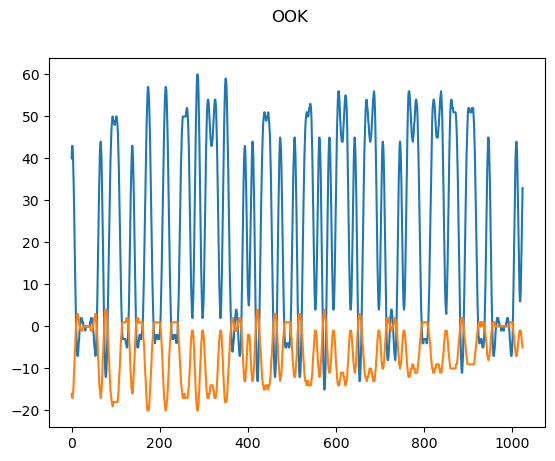

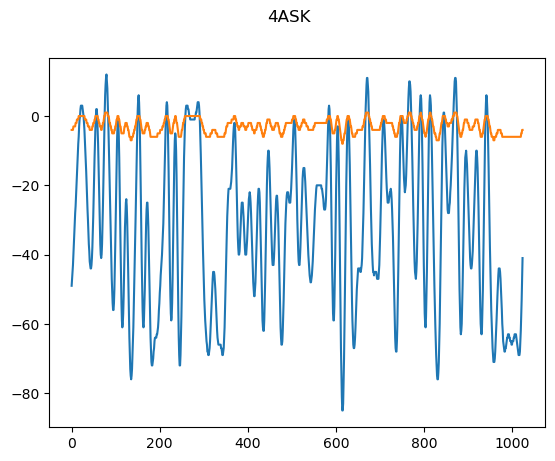

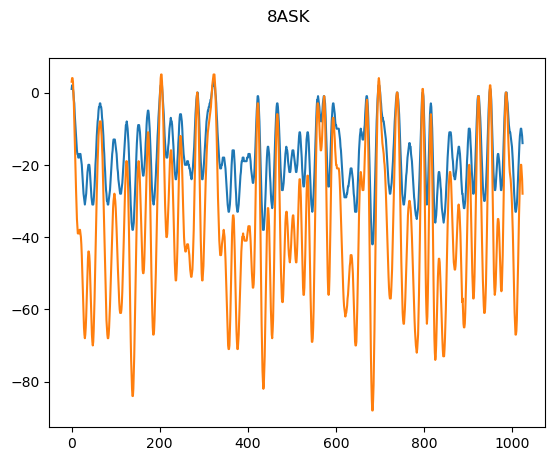

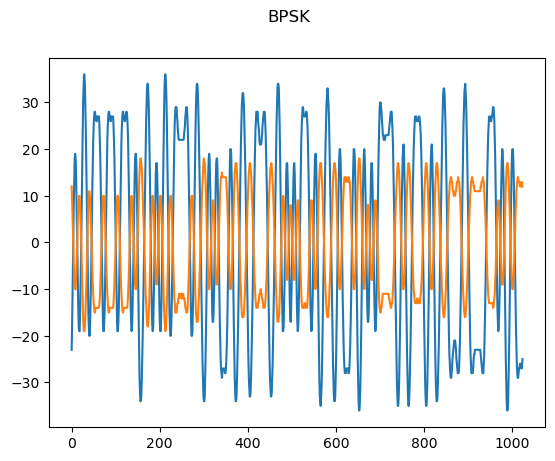

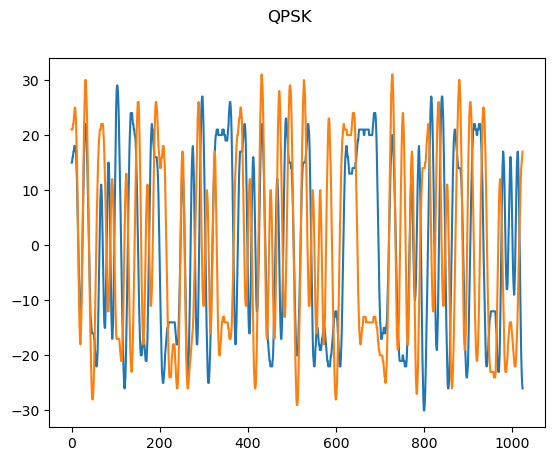

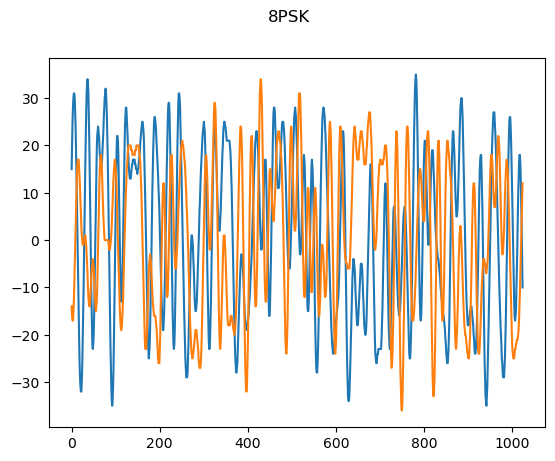

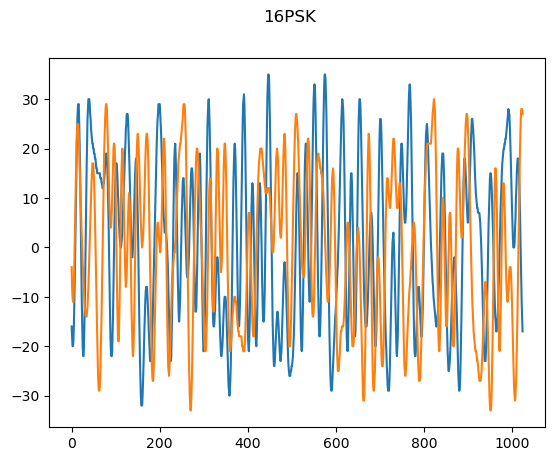

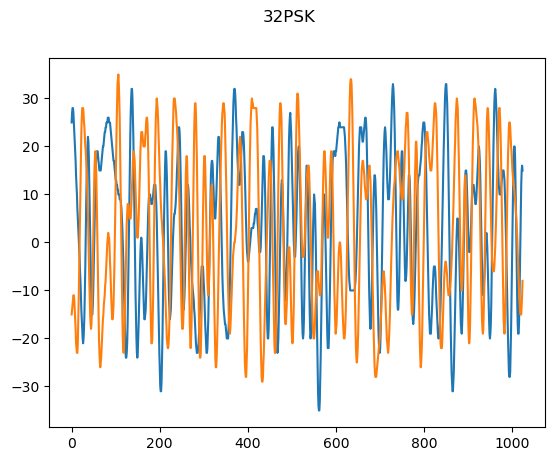

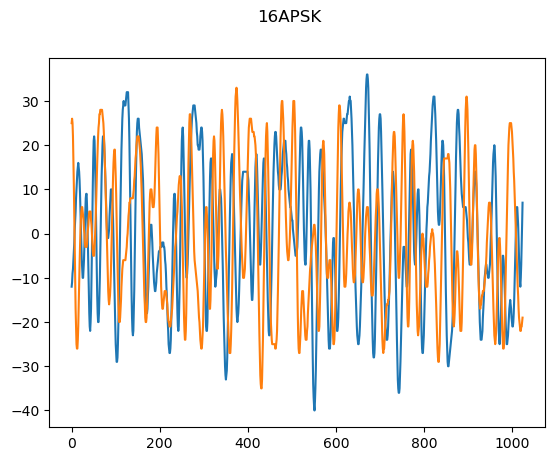

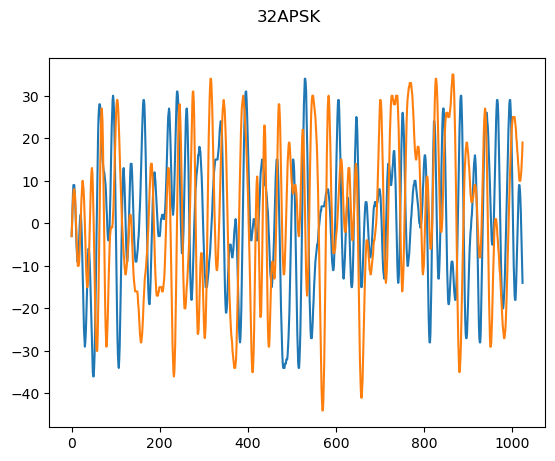

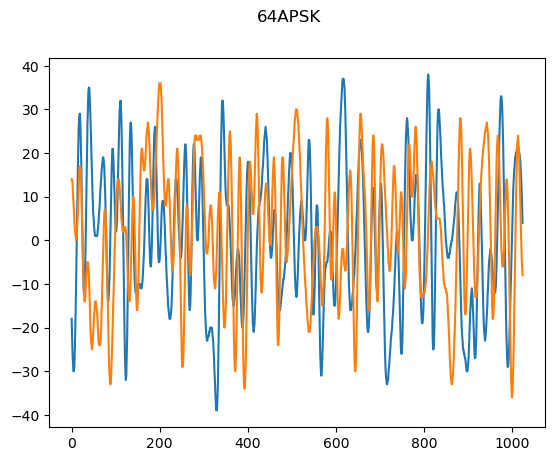

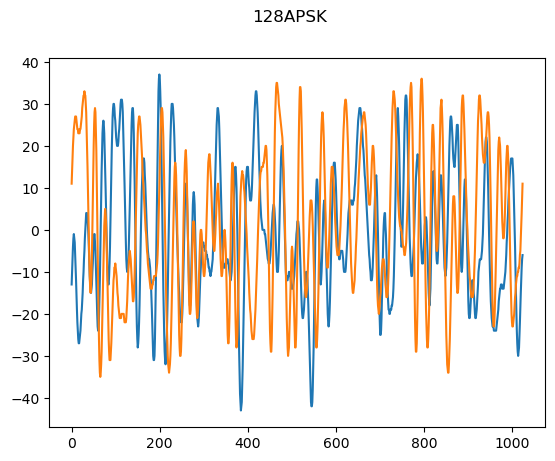

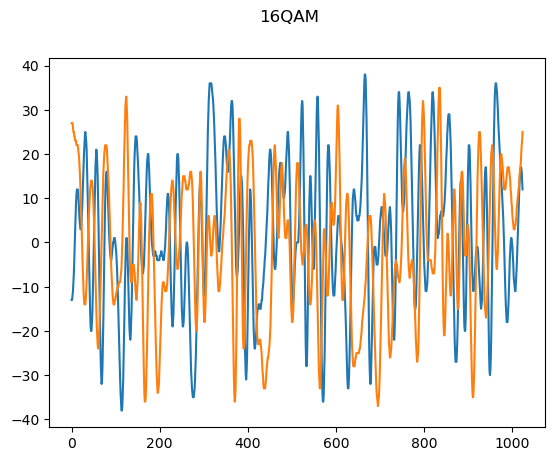

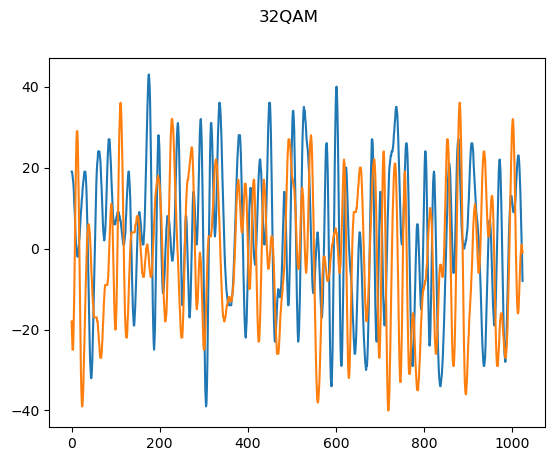

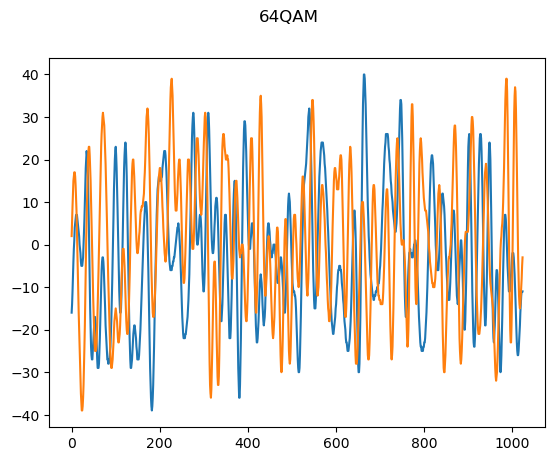

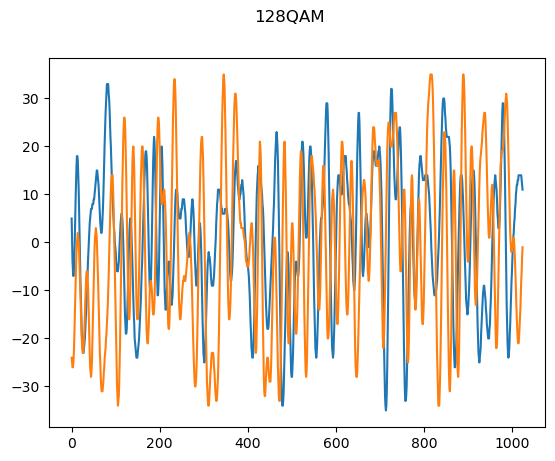

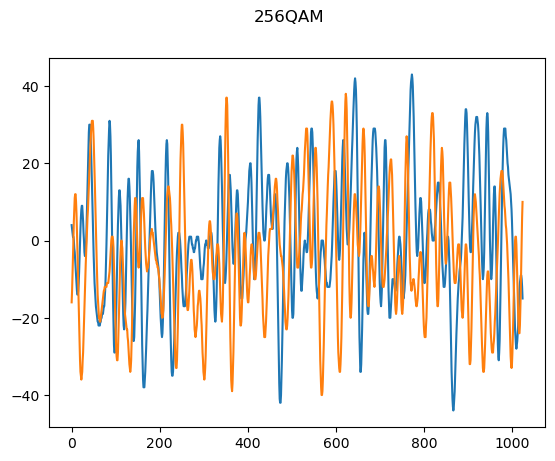

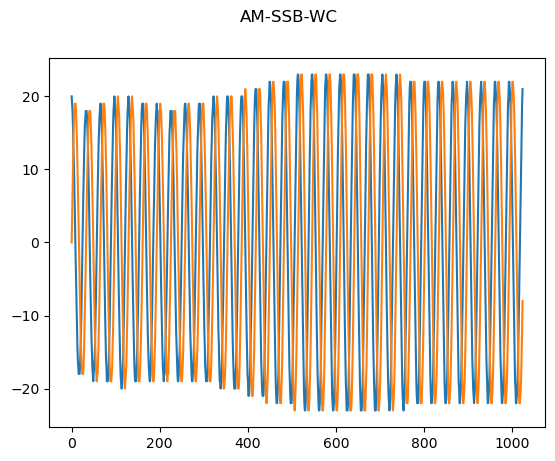

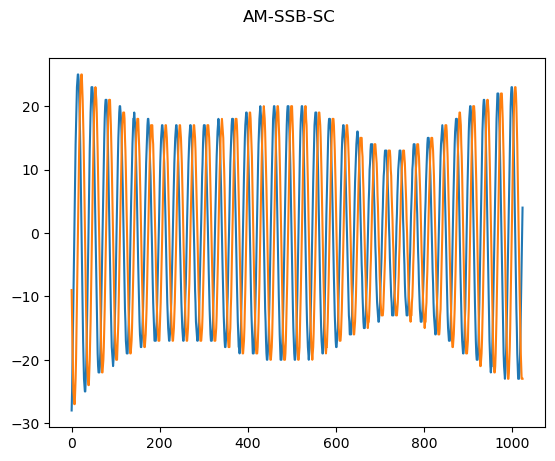

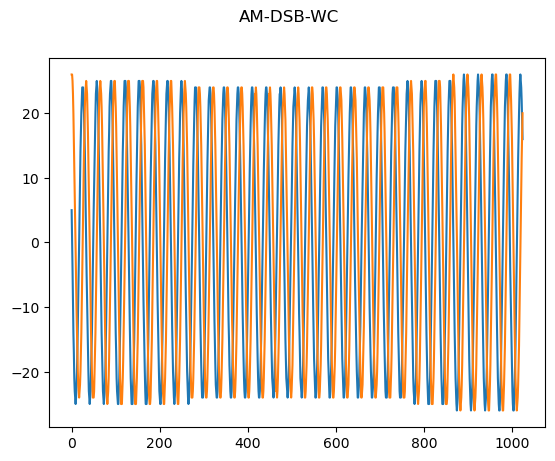

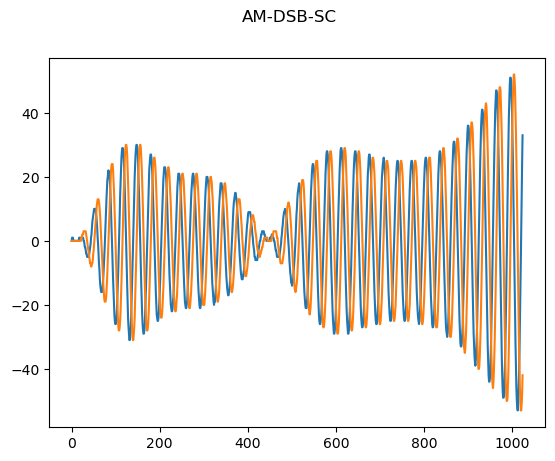

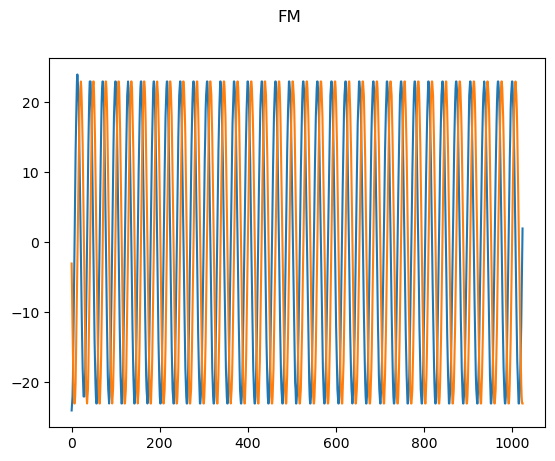

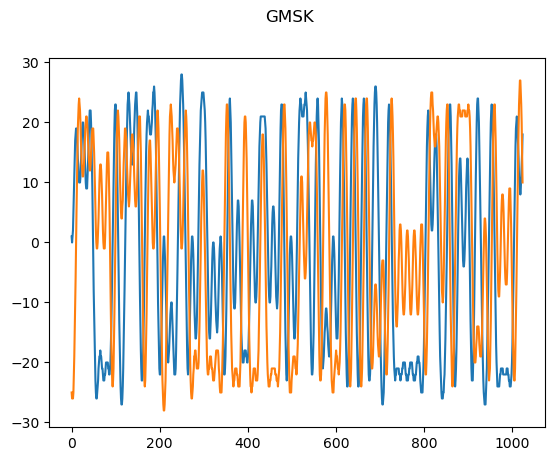

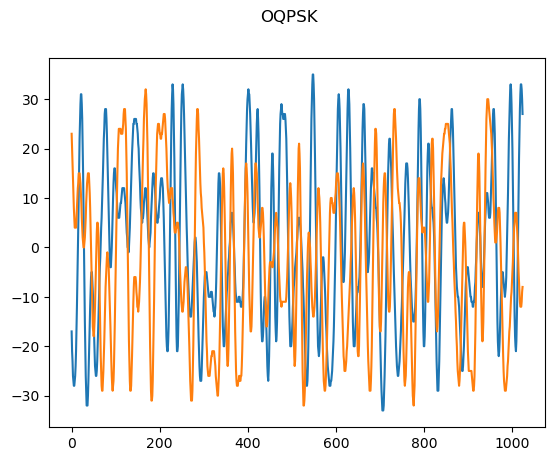

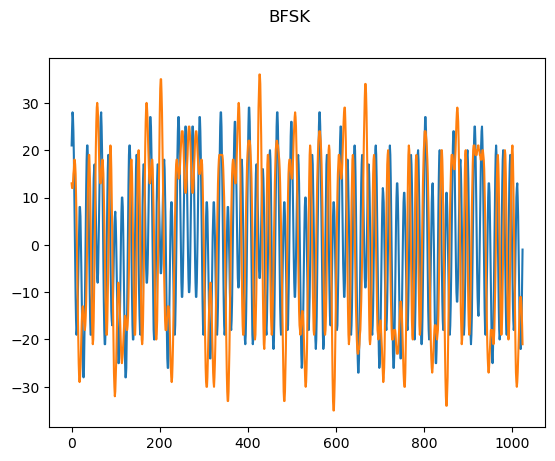

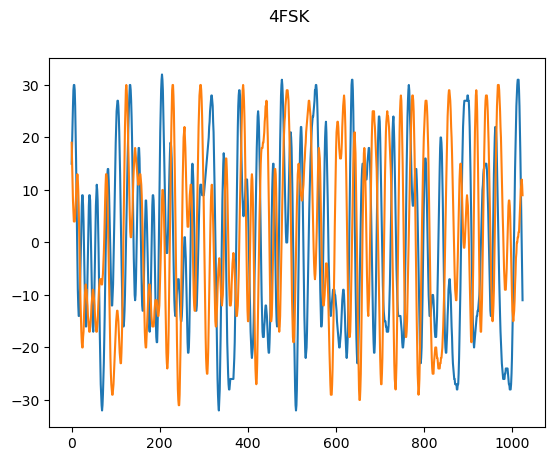

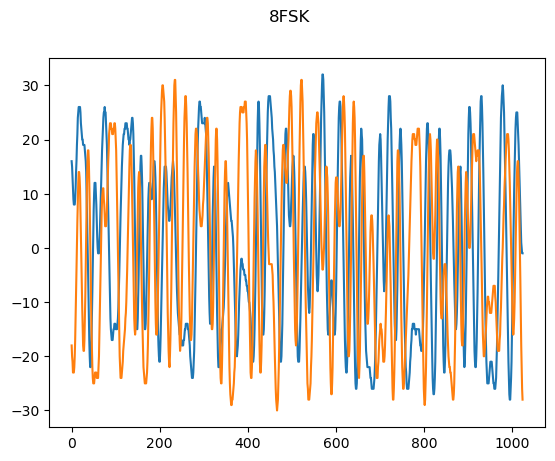

In [6]:
#turn off warning about more than 10 figures plotted
plt.rcParams.update({'figure.max_open_warning': 0})

def my_range(start, end, step):
    while start <= end:
        yield start
        start += step

size = np.size(myData, axis = 0)
step = size//27

for x in my_range(100000, (size-1), step):
  plt.figure()
  plt.suptitle( mods[np.argmax(myMods[x])])
  plt.plot(myData[x,:,0])
  plt.plot(myData[x,:,1])

### Reshape RF data to 2D Matrix
We will reshape both the I and Q data from a 1024 long vector to 2D 1024x1 matrix to be conpatabile with 2D convolution commands supported by the DPU

In [7]:
myData = myData.reshape(myData.shape[0], 1024, 1, 2) 

### Split Data into Training and Validation set
We will use 80% of the data for the Training set and 20% for the Test set. 
The random_state input to the the train_test_split function is set to 0, which means the 80/20 split will be done in a repeatable manner. 

In [8]:
X_train ,X_test ,Y_train ,Y_test, Z_train, Z_test = train_test_split(myData, myMods, mySNRs, test_size=0.2, random_state=0)
X_val, X_test, Y_val, Y_test, Z_val, Z_test = train_test_split(X_test, Y_test, Z_test, test_size=0.5, random_state=0)
print (np.shape(X_test))
print (np.shape(Y_test))
print (np.shape(Z_test))
print (np.shape(X_train))
print (np.shape(Y_train))
print (np.shape(Z_train))
del myData, myMods, mySNRs

(287540, 1024, 1, 2)
(287540, 27)
(287540, 1)
(2300313, 1024, 1, 2)
(2300313, 27)
(2300313, 1)


In [9]:
X_test.tofile('test_data.bin')
Y_test.tofile('test_labels.bin')
Z_test.tofile('test_snrs.bin')
# b = np.loadtxt('test1.txt', dtype=int)
# a == b

In [9]:
def best_snr_data(X, Y, Z):
    best_snr_indices = np.where(np.any(Z == 30, axis=1))
    return X[best_snr_indices], Y[best_snr_indices]

In [10]:
X_best_test, Y_best_test = best_snr_data(X_test, Y_test, Z_test)
print(np.shape(X_best_test))
print(np.shape(Y_best_test))

(11006, 1024, 1, 2)
(11006, 27)


In [11]:
def usable_snr_data(X, Y, Z):
    best_snr_indices = np.where(np.any(Z >= 6, axis=1))
    return X[best_snr_indices], Y[best_snr_indices]

In [12]:
X_usable_test, Y_usable_test = usable_snr_data(X_test, Y_test, Z_test)
print(np.shape(X_usable_test))
print(np.shape(Y_usable_test))

(143747, 1024, 1, 2)
(143747, 27)


# Fast Fine-Tuning Calibration Dataset Preparation Function

In [13]:
def get_balanced_snr_samples(X, Y, Z, samples_per_snr=30, seed=None):
    """
    Returns X and Y containing `samples_per_snr` randomly selected samples
    for each unique SNR value in Z.

    Parameters:
    - X: Input data (numpy array)
    - Y: Labels corresponding to X
    - Z: SNR values for each sample
    - samples_per_snr: Number of samples to select for each SNR value
    - seed: Optional random seed for reproducibility

    Returns:
    - Tuple of (X_filtered, Y_filtered)
    """
    if seed is not None:
        np.random.seed(seed)

    unique_snrs = np.unique(Z)
    selected_X = []
    selected_Y = []

    for snr in unique_snrs:
        indices = np.where(Z == snr)[0]
        if len(indices) < samples_per_snr:
            raise ValueError(f"Not enough samples for SNR {snr}: requested {samples_per_snr}, but found {len(indices)}")
        
        chosen_indices = np.random.choice(indices, samples_per_snr, replace=False)
        selected_X.append(X[chosen_indices])
        selected_Y.append(Y[chosen_indices])

    return np.concatenate(selected_X), np.concatenate(selected_Y)


## Build a Simple Resnet  Model 


This resnet model was inspired by the model disussed in the following paper <br>
Over-the-Air Deep Learning Based Radio Signal Classification, <br>
IEEE JOURNAL OF SELECTED TOPICS IN SIGNAL PROCESSING, VOL. 12, NO. 1, <br>
FEBRUARY 2018 

In [13]:
input_shp = list(X_train.shape[1:])
print("Dataset Shape={0} CNN Model Input layer={1}".format(X_train.shape, input_shp))
classes = mods

Dataset Shape=(2300313, 1024, 1, 2) CNN Model Input layer=[1024, 1, 2]


Here we construct a resnet block which will be used multiple times in our model. In order to be compatabile with the Vitis-AI compilation tools we need to use a square kernel size (2x2) for the MaxPooling layer. Since the data is rectangular 1024x1, 512x1, ... we have enabled padding so the a square kernel size can be used.

In [10]:
def resnet_block(input_data, in_filters, out_filters, conv_size):
  x = Conv2D(in_filters, conv_size, activation=None, padding='same')(input_data)
  x = BatchNormalization()(x)
  x = Add()([x, input_data])
  x = Activation('relu')(x)
  x = Conv2D(out_filters, conv_size, activation=None, padding='same')(x) 
  x = BatchNormalization()(x)
  x = MaxPooling2D(2, strides = (2,1), padding = 'same') (x)
  return x



Here we construct a model with 5 resnet_blocks.

In [12]:
num_resnet_blocks = 5
kernel_size = 5,1

rf_input = Input(shape=input_shp, name = 'rf_input')

x = Conv2D(16, (kernel_size), activation=None, padding='same')(rf_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)

in_filters = 16
out_filters = 32
for i in range(num_resnet_blocks):
    if (i == num_resnet_blocks-1):
        out_filters = num_classes
    x = resnet_block(x, in_filters, out_filters, kernel_size)
    in_filters = in_filters * 2
    out_filters = out_filters * 2

flatten = Flatten()(x)
dropout_1 = Dropout(0.5)(flatten)
dense_1 = Dense(num_classes, activation='relu')(dropout_1)        
softmax = Activation('softmax', name = 'softmax')(dense_1)

optimizer= Adam(learning_rate=0.00060)
model = Model(rf_input, softmax)
model.compile(loss='categorical_crossentropy', metrics=["accuracy"])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 rf_input (InputLayer)       [(None, 1024, 1, 2)]         0         []                            
                                                                                                  
 conv2d_11 (Conv2D)          (None, 1024, 1, 16)          176       ['rf_input[0][0]']            
                                                                                                  
 batch_normalization_11 (Ba  (None, 1024, 1, 16)          64        ['conv2d_11[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_6 (Activation)   (None, 1024, 1, 16)          0         ['batch_normalization_11[0

In [11]:
rf_input = Input(shape=input_shp, name = 'rf_input')

x = Conv2D(filters=16, 
           kernel_size=(2, 1),      
           strides=(1, 1), 
           kernel_initializer='he_uniform', 
           padding='same')(rf_input)
x = Activation('relu')(x)
x = AveragePooling2D(pool_size=(4, 1), 
                     strides=(2, 1))(x)
x = Conv2D(filters=32, 
           kernel_size=(1, 1),      
           strides=(1, 1), 
           kernel_initializer='he_uniform',
           padding='same')(x)
x = Activation('relu')(x)
x = AveragePooling2D(pool_size=(2, 1), 
                     strides=(2, 1))(x)
x = Conv2D(filters=64, 
           kernel_size=(2, 1),      
           strides=(1, 1), 
           kernel_initializer='he_uniform',
           padding='same')(x)
x = Activation('relu')(x)
# x = BatchNormalization()(x)
x = AveragePooling2D(pool_size=(4, 1), 
                     strides=(4, 1))(x)
x = Flatten()(x)

rf_output = Dense(27, 
                  kernel_initializer='glorot_uniform', 
                  activation='softmax')(x)

optimizer= Adam(learning_rate=0.00060)
model_0 = Model(rf_input, rf_output)
model_0.compile(loss='categorical_crossentropy', metrics=["accuracy"])

print(model_0.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rf_input (InputLayer)       [(None, 1024, 1, 2)]      0         
                                                                 
 conv2d (Conv2D)             (None, 1024, 1, 16)       80        
                                                                 
 activation (Activation)     (None, 1024, 1, 16)       0         
                                                                 
 average_pooling2d (Average  (None, 511, 1, 16)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 511, 1, 32)        544       
                                                                 
 activation_1 (Activation)   (None, 511, 1, 32)        0         
                                                             

2025-06-16 21:24:47.753597: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1750123487.754551 3693060 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22792 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:01:00.0, compute capability: 7.5


In [12]:
rf_input_1 = Input(shape=input_shp, name = 'rf_input_1')

x = Conv2D(filters=16, 
           kernel_size=(1, 1),      
           strides=(1, 1), 
           kernel_initializer='he_uniform',
           activation='relu', 
           padding='same')(rf_input_1)
x = AveragePooling2D(pool_size=(2, 1), 
                     strides=(2, 1))(x)
x = Conv2D(filters=32, 
           kernel_size=(1, 1),      
           strides=(1, 1), 
           kernel_initializer='he_uniform',
           activation='relu', 
           padding='same')(x)
# x = BatchNormalization()(x)
x = AveragePooling2D(pool_size=(4, 1), 
                     strides=(2, 1))(x)
x = Conv2D(filters=64, 
           kernel_size=(2, 1),      
           strides=(1, 1), 
           kernel_initializer='he_uniform',
           activation='relu', 
           padding='same')(x)
# x = BatchNormalization()(x)
x = AveragePooling2D(pool_size=(2, 1), 
                     strides=(2, 1))(x)
x = Conv2D(filters=32, 
           kernel_size=(2, 1),      
           strides=(1, 1), 
           kernel_initializer='he_uniform',
           activation='relu', 
           padding='same')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(16, 
          kernel_initializer='he_uniform', 
          activation='relu')(x)

rf_output_1 = Dense(27, 
                  kernel_initializer='glorot_uniform', 
                  activation='softmax')(x)

optimizer= Adam(learning_rate=0.00060)
model_1 = Model(rf_input_1, rf_output_1)
model_1.compile(loss='categorical_crossentropy', metrics=["accuracy"])

print(model_1.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rf_input_1 (InputLayer)     [(None, 1024, 1, 2)]      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 1024, 1, 16)       48        
                                                                 
 average_pooling2d_3 (Avera  (None, 512, 1, 16)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_4 (Conv2D)           (None, 512, 1, 32)        544       
                                                                 
 average_pooling2d_4 (Avera  (None, 255, 1, 32)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 255, 1, 64)        4160

In [13]:
rf_input_2 = Input(shape=input_shp, name = 'rf_input')

x = Conv2D(filters=32, 
           kernel_size=(2, 1),      
           strides=(1, 1), 
           kernel_initializer='he_uniform',
           activation='relu', 
           padding='same')(rf_input_2)
x = AveragePooling2D(pool_size=(2, 1), 
                     strides=(2, 1))(x)
x = Conv2D(filters=4, 
           kernel_size=(1, 1),      
           strides=(1, 1), 
           kernel_initializer='he_uniform',
           activation='relu', 
           padding='same')(x)
x = AveragePooling2D(pool_size=(2, 1), 
                     strides=(2, 1))(x)
x = Conv2D(filters=32, 
           kernel_size=(2, 1),      
           strides=(1, 1), 
           kernel_initializer='he_uniform',
           activation='relu', 
           padding='same')(x)
x = AveragePooling2D(pool_size=(4, 1), 
                     strides=(2, 1))(x)
x = Conv2D(filters=64, 
           kernel_size=(2, 1),      
           strides=(1, 1), 
           kernel_initializer='he_uniform',
           activation='relu', 
           padding='same')(x)
# x = BatchNormalization()(x)
x = AveragePooling2D(pool_size=(4, 1), 
                     strides=(2, 1))(x)
x = GlobalAveragePooling2D()(x)
x = Dense(16, 
          kernel_initializer='he_uniform', 
          activation='relu')(x)
x = Dense(16, 
          kernel_initializer='he_uniform', 
          activation='relu')(x)
x = Dense(16, 
          kernel_initializer='he_uniform', 
          activation='relu')(x)

rf_output_2 = Dense(27, 
                  kernel_initializer='glorot_uniform', 
                  activation='softmax')(x)

optimizer= Adam(learning_rate=0.00060)
model_2 = Model(rf_input_2, rf_output_2)
model_2.compile(loss='categorical_crossentropy', metrics=["accuracy"])

print(model_2.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rf_input (InputLayer)       [(None, 1024, 1, 2)]      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 1024, 1, 32)       160       
                                                                 
 average_pooling2d_6 (Avera  (None, 512, 1, 32)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_8 (Conv2D)           (None, 512, 1, 4)         132       
                                                                 
 average_pooling2d_7 (Avera  (None, 256, 1, 4)         0         
 gePooling2D)                                                    
                                                                 
 conv2d_9 (Conv2D)           (None, 256, 1, 32)        288 

In [29]:
rf_input_3 = Input(shape=input_shp, name = 'rf_input')

x = Conv2D(filters=64, 
           kernel_size=(2, 1),      
           strides=(1, 1), 
           kernel_initializer='he_uniform',
           activation='selu', 
           padding='same')(rf_input_3)
x = AveragePooling2D(pool_size=(4, 1), 
                     strides=(2, 1))(x)
x = Conv2D(filters=32, 
           kernel_size=(2, 1),      
           strides=(1, 1), 
           kernel_initializer='he_uniform',
           activation='selu', 
           padding='same')(x)
x = BatchNormalization()(x)
x = AveragePooling2D(pool_size=(2, 1), 
                     strides=(2, 1))(x)
x = Conv2D(filters=16, 
           kernel_size=(1, 1),      
           strides=(1, 1), 
           kernel_initializer='he_uniform',
           activation='selu', 
           padding='same')(x)
x = AveragePooling2D(pool_size=(4, 1), 
                     strides=(4, 1))(x)
x = Conv2D(filters=8, 
           kernel_size=(1, 1),      
           strides=(1, 1), 
           kernel_initializer='he_uniform',
           activation='selu', 
           padding='same')(x)
x = AveragePooling2D(pool_size=(4, 1), 
                     strides=(2, 1))(x)
x = Conv2D(filters=64, 
           kernel_size=(1, 1),      
           strides=(1, 1), 
           kernel_initializer='he_uniform',
           activation='selu', 
           padding='same')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(16, 
          kernel_initializer='he_uniform', 
          activation='selu')(x)

rf_output_3 = Dense(27, 
                  kernel_initializer='glorot_uniform', 
                  activation='softmax')(x)

optimizer= Adam(learning_rate=0.00060)
model_3 = keras.Model(rf_input_3, rf_output_3)
model_3.compile(loss='categorical_crossentropy', metrics=["accuracy"])

print(model_3.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rf_input (InputLayer)       [(None, 1024, 1, 2)]      0         
                                                                 
 conv2d_19 (Conv2D)          (None, 1024, 1, 64)       320       
                                                                 
 average_pooling2d_7 (Averag  (None, 511, 1, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_20 (Conv2D)          (None, 511, 1, 32)        4128      
                                                                 
 batch_normalization_14 (Bat  (None, 511, 1, 32)       128       
 chNormalization)                                                
                                                                 
 average_pooling2d_8 (Averag  (None, 255, 1, 32)       0   

In [17]:
rf_input_4 = Input(shape=input_shp, name = 'rf_input')

x = Conv2D(filters=8, 
           kernel_size=(1, 1),      
           strides=(1, 1), 
           kernel_initializer='he_uniform',
           activation='selu', 
           padding='same')(rf_input_4)
x = AveragePooling2D(pool_size=(4, 1), 
                     strides=(4, 1))(x)
x = Conv2D(filters=64, 
           kernel_size=(2, 1),      
           strides=(1, 1), 
           kernel_initializer='he_uniform',
           activation='selu', 
           padding='same')(x)
x = BatchNormalization()(x)
x = AveragePooling2D(pool_size=(2, 1), 
                     strides=(2, 1))(x)
x = Conv2D(filters=32, 
           kernel_size=(1, 1),      
           strides=(1, 1), 
           kernel_initializer='he_uniform',
           activation='selu', 
           padding='same')(x)
x = AveragePooling2D(pool_size=(4, 1), 
                     strides=(4, 1))(x)
x = Conv2D(filters=8, 
           kernel_size=(2, 1),      
           strides=(1, 1), 
           kernel_initializer='he_uniform',
           activation='selu', 
           padding='same')(x)
x = AveragePooling2D(pool_size=(2, 1), 
                     strides=(2, 1))(x)
x = Conv2D(filters=32, 
           kernel_size=(2, 1),      
           strides=(1, 1), 
           kernel_initializer='he_uniform',
           activation='selu', 
           padding='same')(x)
x = AveragePooling2D(pool_size=(2, 1), 
                     strides=(2, 1))(x)
x = Conv2D(filters=16, 
           kernel_size=(1, 1),      
           strides=(1, 1), 
           kernel_initializer='he_uniform',
           activation='selu', 
           padding='same')(x)
x = AveragePooling2D(pool_size=(2, 1), 
                     strides=(2, 1))(x)
x = Flatten()(x)

rf_output_4 = Dense(27, 
                  kernel_initializer='glorot_uniform', 
                  activation='softmax')(x)

optimizer= Adam(learning_rate=0.00060)
model_4 = keras.Model(rf_input_4, rf_output_4)
model_4.compile(loss='categorical_crossentropy', metrics=["accuracy"])

print(model_4.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rf_input (InputLayer)       [(None, 1024, 1, 2)]      0         
                                                                 
 conv2d_16 (Conv2D)          (None, 1024, 1, 8)        24        
                                                                 
 average_pooling2d_14 (Avera  (None, 256, 1, 8)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_17 (Conv2D)          (None, 256, 1, 64)        1088      
                                                                 
 batch_normalization_5 (Batc  (None, 256, 1, 64)       256       
 hNormalization)                                                 
                                                                 
 average_pooling2d_15 (Avera  (None, 128, 1, 64)       0   

Lets verify that our model is working. Because the weight are unitialize, all the probabilites will be close to a random guess of 0.045 (1/22)

In [10]:
predict = model.predict(X_test[0:1])
print(predict)

1/1 [==============================] - 0s 54ms/step
[[1.2320924e-19 5.7061440e-26 4.3721794e-20 6.6139763e-31 1.5748797e-14
  2.0275591e-28 8.3819619e-15 9.9999857e-01 6.6054347e-14 1.6777908e-22
  1.1513969e-20 7.0811458e-35 7.1357495e-22 1.5910416e-22 7.8490875e-10
  5.1617885e-12 1.9106598e-10 1.4646413e-06 1.7175178e-24 9.2989776e-27
  3.7159284e-22 3.3832580e-17 4.5192465e-15 1.1373546e-18 1.2919453e-28
  6.7315891e-19 4.4337815e-11]]


## TRAIN

### Set up batch and epoch size.

In [11]:
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

### Early stoping callback 
Will end training after 5 epochs with no accuracy improvement on test data set

In [15]:
### Callback
checkpoint_dir = 'resnet_checkpoints'

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_dir + '/model_2_relu_no_bn.h5', 
                                                 verbose = 1,
                                                 save_best_only=True, 
                                                 save_weights_only=False,
                                                 mode='auto')
# tb_callback = TensorBoard(log_dir=os.path.join('learner_logs', 'model_0'),
#                           histogram_freq=1,
#                           profile_batch=0)

callbacks = [cp_callback]

### Start Training

In [16]:
history = model.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=1,
    validation_data=(X_test, Y_test),
    callbacks = [ cp_callback ]
    )


Epoch 1/100


I0000 00:00:1749575935.310944  179258 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749575936.070197  179279 service.cc:152] XLA service 0x798dc1984de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749575936.070211  179279 service.cc:160]   StreamExecutor device (0): NVIDIA TITAN RTX, Compute Capability 7.5
2025-06-10 13:18:56.073051: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749575936.134695  179279 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2247/2247 [==============================] - ETA: 0s - loss: 1.6648 - accuracy: 0.4478
Epoch 1: val_loss improved from inf to 1.76901, saving model to resnet_checkpoints/baseline_model.h5
2247/2247 [==============================] - 213s 93ms/step - loss: 1.6648 - accuracy: 0.4478 - val_loss: 1.7690 - val_accuracy: 0.4414
Epoch 2/100
   1/2247 [..............................] - ETA: 3:19 - loss: 1.5041 - accuracy: 0.4961

/home/ashwin/anaconda3/envs/vai-tf2-cu122-pip/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2246/2247 [============================>.] - ETA: 0s - loss: 1.3636 - accuracy: 0.5566
Epoch 2: val_loss improved from 1.76901 to 1.42193, saving model to resnet_checkpoints/baseline_model.h5
2247/2247 [==============================] - 211s 94ms/step - loss: 1.3636 - accuracy: 0.5566 - val_loss: 1.4219 - val_accuracy: 0.5434
Epoch 3/100
2246/2247 [============================>.] - ETA: 0s - loss: 1.2830 - accuracy: 0.5911
Epoch 3: val_loss improved from 1.42193 to 1.33478, saving model to resnet_checkpoints/baseline_model.h5
2247/2247 [==============================] - 212s 94ms/step - loss: 1.2829 - accuracy: 0.5911 - val_loss: 1.3348 - val_accuracy: 0.5737
Epoch 4/100
2246/2247 [============================>.] - ETA: 0s - loss: 1.2399 - accuracy: 0.6085
Epoch 4: val_loss improved from 1.33478 to 1.27160, saving model to resnet_checkpoints/baseline_model.h5
2247/2247 [==============================] - 213s 95ms/step - loss: 1.2399 - accuracy: 0.6085 - val_loss: 1.2716 - val_accuracy:

KeyboardInterrupt: 

In [ ]:
model_0.fit(
    X_train,
    Y_train,
    epochs=nb_epoch,
    validation_data=(X_val, Y_val),
    verbose=1,
    callbacks=callbacks
)

K.clear_session()
gc.collect()

# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_dir + '/model_1_relu.h5', 
#                                                  verbose = 1,
#                                                  save_best_only=True, 
#                                                  save_weights_only=False,
#                                                  mode='auto')

# tb_callback = TensorBoard(log_dir=os.path.join('learner_logs', 'model_1'),
#                           histogram_freq=1,
#                           profile_batch=0)

Epoch 1/100


I0000 00:00:1749495604.226880   68633 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749495604.395319   68633 service.cc:152] XLA service 0x78490e7fccc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749495604.395333   68633 service.cc:160]   StreamExecutor device (0): NVIDIA TITAN RTX, Compute Capability 7.5
2025-06-09 15:00:04.398225: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749495604.462771   68633 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71885/71885 [==============================] - ETA: 0s - loss: 2.1342 - accuracy: 0.3064
Epoch 1: val_loss improved from inf to 2.05713, saving model to resnet_checkpoints/model_0_relu_sep_activation_no_bn.h5
71885/71885 [==============================] - 78s 1ms/step - loss: 2.1342 - accuracy: 0.3064 - val_loss: 2.0571 - val_accuracy: 0.3247
Epoch 2/100
  137/71885 [..............................] - ETA: 1:19 - loss: 2.0582 - accuracy: 0.3230

/home/ashwin/anaconda3/envs/vai-tf2-cu122-pip/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41798/71885 [================>.............] - ETA: 29s - loss: 2.0295 - accuracy: 0.3383

In [16]:
model_1.fit(
    X_train,
    Y_train,
    epochs=nb_epoch,
    validation_data=(X_val, Y_val),
    verbose=1,
    callbacks=callbacks
)

K.clear_session()
gc.collect()

Epoch 1/100


2025-06-10 03:03:38.151752: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8907
2025-06-10 03:03:38.260262: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7129d007b8b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-10 03:03:38.260274: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA TITAN RTX, Compute Capability 7.5
2025-06-10 03:03:38.262153: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-10 03:03:38.316941: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71885/71885 [==============================] - ETA: 0s - loss: 2.1942 - accuracy: 0.2721
Epoch 1: val_loss improved from inf to 1.88572, saving model to resnet_checkpoints/model_1_relu_sep_activation_no_bn.h5
71885/71885 [==============================] - 86s 1ms/step - loss: 2.1942 - accuracy: 0.2721 - val_loss: 1.8857 - val_accuracy: 0.3713
Epoch 2/100
71866/71885 [============================>.] - ETA: 0s - loss: 1.8556 - accuracy: 0.3839
Epoch 2: val_loss improved from 1.88572 to 1.78188, saving model to resnet_checkpoints/model_1_relu_sep_activation_no_bn.h5
71885/71885 [==============================] - 84s 1ms/step - loss: 1.8556 - accuracy: 0.3839 - val_loss: 1.7819 - val_accuracy: 0.4027
Epoch 3/100
71859/71885 [============================>.] - ETA: 0s - loss: 1.7876 - accuracy: 0.4032
Epoch 3: val_loss improved from 1.78188 to 1.74131, saving model to resnet_checkpoints/model_1_relu_sep_activation_no_bn.h5
71885/71885 [==============================] - 84s 1ms/step - loss: 1

KeyboardInterrupt: 

In [16]:
model_2.fit(
    X_train,
    Y_train,
    epochs=nb_epoch,
    validation_data=(X_val, Y_val),
    verbose=1,
    callbacks=callbacks
)

K.clear_session()
gc.collect()

Epoch 1/100


2025-06-15 20:52:31.070576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8907
2025-06-15 20:52:31.182204: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x75b2a2e6d150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-15 20:52:31.182216: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA TITAN RTX, Compute Capability 7.5
2025-06-15 20:52:31.184162: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-15 20:52:31.229888: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71885/71885 [==============================] - ETA: 0s - loss: 2.0907 - accuracy: 0.3027
Epoch 1: val_loss improved from inf to 1.82620, saving model to resnet_checkpoints/model_2_relu_no_bn.h5
71885/71885 [==============================] - 95s 1ms/step - loss: 2.0907 - accuracy: 0.3027 - val_loss: 1.8262 - val_accuracy: 0.3774
Epoch 2/100
71872/71885 [============================>.] - ETA: 0s - loss: 1.8237 - accuracy: 0.3846
Epoch 2: val_loss did not improve from 1.82620
71885/71885 [==============================] - 95s 1ms/step - loss: 1.8237 - accuracy: 0.3846 - val_loss: 1.8932 - val_accuracy: 0.3675
Epoch 3/100
71882/71885 [============================>.] - ETA: 0s - loss: 1.9103 - accuracy: 0.3680
Epoch 3: val_loss did not improve from 1.82620
71885/71885 [==============================] - 95s 1ms/step - loss: 1.9103 - accuracy: 0.3680 - val_loss: 1.9271 - val_accuracy: 0.3659
Epoch 4/100
71847/71885 [============================>.] - ETA: 0s - loss: 1.9994 - accuracy: 0.3558
E

KeyboardInterrupt: 

In [ ]:
model_3.fit(
    X_train,
    Y_train,
    epochs=nb_epoch,
    validation_data=(X_val, Y_val),
    verbose=1,
    callbacks=callbacks
)

K.clear_session()
gc.collect()

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_dir + '/model_4.h5', 
                                                 verbose = 1,
                                                 save_best_only=True, 
                                                 save_weights_only=False,
                                                 mode='auto')

tb_callback = TensorBoard(log_dir=os.path.join('learner_logs', 'model_4'),
                          histogram_freq=1,
                          profile_batch=0)

In [ ]:
model_4.fit(
    X_train,
    Y_train,
    epochs=nb_epoch,
    validation_data=(X_val, Y_val),
    verbose=1,
    callbacks=callbacks
)

K.clear_session()
gc.collect()

## Training Completed
Reload the best weights once training is fininsed. 

In [16]:
# best_checkpoint = checkpoint_dir + '/best_checkpoint.h5'
# model.load_weights(best_checkpoint)
# !mkdir -p fp_model
# model.save ('fp_model/resnet_fp_model.h5')

In [16]:
model_0 = tf.keras.models.load_model('resnet_checkpoints/model_0_relu.h5')

2025-04-27 15:58:47.314474: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-27 15:58:47.329212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-27 15:58:47.329327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [15]:
model_1 = tf.keras.models.load_model('resnet_checkpoints/model_1.h5', compile=False)
model_1.compile(loss='categorical_crossentropy', metrics=["accuracy"])

2025-05-01 17:59:34.226760: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-01 17:59:34.242921: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-01 17:59:34.243039: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-05-01 17:59:34.243372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the

In [1]:
model_2 = tf.keras.models.load_model('resnet_checkpoints/model_2_relu_100ep.h5')

2025-06-09 14:17:35.336965: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-09 14:17:35.343650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749493055.351132   55339 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749493055.353511   55339 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749493055.359366   55339 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [15]:
### Callback
checkpoint_dir = 'resnet_checkpoints'
#os.mkdir(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_dir + '/model_0_relu_sep_activation_no_bn_ft.h5', 
                                                 verbose = 1,
                                                 save_best_only=True, 
                                                 save_weights_only=False,
                                                 mode='auto')

In [19]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model
model_0 = tf.keras.models.load_model('resnet_checkpoints/model_0_relu_sep_activation_no_bn.h5')

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model_0)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

q_aware_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rf_input (InputLayer)       [(None, 1024, 1, 2)]      0         
                                                                 
 quantize_layer_3 (Quantize  (None, 1024, 1, 2)        3         
 Layer)                                                          
                                                                 
 quant_conv2d (QuantizeWrap  (None, 1024, 1, 16)       81        
 perV2)                                                          
                                                                 
 quant_activation (Quantize  (None, 1024, 1, 16)       3         
 WrapperV2)                                                      
                                                                 
 quant_average_pooling2d (Q  (None, 511, 1, 16)        3         
 uantizeWrapperV2)                                           

In [20]:
calib_size = int((1/60) * len(X_train))
X_train_subset = X_train[0:calib_size] # out of 60000
Y_train_subset = Y_train[0:calib_size]

q_aware_model.fit(X_train_subset, 
                  Y_train_subset,
                  batch_size=batch_size, 
                  epochs=10, 
                  validation_data=(X_val, Y_val),
                  callbacks=[cp_callback])

Epoch 1/10
38/38 [==============================] - ETA: 0s - loss: 3.2989 - accuracy: 0.0359
Epoch 1: val_loss improved from 3.29584 to 3.29519, saving model to resnet_checkpoints/model_0_relu_sep_activation_no_bn_ft.h5
38/38 [==============================] - 4s 71ms/step - loss: 3.2989 - accuracy: 0.0359 - val_loss: 3.2952 - val_accuracy: 0.0373
Epoch 2/10
37/38 [============================>.] - ETA: 0s - loss: 3.2978 - accuracy: 0.0359
Epoch 2: val_loss improved from 3.29519 to 3.29422, saving model to resnet_checkpoints/model_0_relu_sep_activation_no_bn_ft.h5
38/38 [==============================] - 2s 58ms/step - loss: 3.2978 - accuracy: 0.0359 - val_loss: 3.2942 - val_accuracy: 0.0374
Epoch 3/10
37/38 [============================>.] - ETA: 0s - loss: 3.2953 - accuracy: 0.0358
Epoch 3: val_loss did not improve from 3.29422
38/38 [==============================] - 2s 56ms/step - loss: 3.2953 - accuracy: 0.0359 - val_loss: 3.2951 - val_accuracy: 0.0373
Epoch 4/10
37/38 [=========

In [21]:
q_aware_model.evaluate(
   X_test, Y_test, verbose=0)

[3.2823569774627686, 0.040171802043914795]

In [35]:
with tfmot.quantization.keras.quantize_scope():
    q_aware_model = tf.keras.models.load_model('resnet_checkpoints/model_0_relu_sep_activation_no_bn_ft.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # 🔑 Add this line
tflite_quant_model = converter.convert()

quantized_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpbfh3vrd_/assets


INFO:tensorflow:Assets written to: /tmp/tmpbfh3vrd_/assets
/home/ashwin/anaconda3/envs/vai-tf2-cu122-pip/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1749543631.797572  127944 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1749543631.797583  127944 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-06-10 04:20:31.797674: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpbfh3vrd_
2025-06-10 04:20:31.798860: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-06-10 04:20:31.798865: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpbfh3vrd_
2025-06-10 04:20:31.805811: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-06-10 04:20:31.842105: I tensorflow/cc/saved_mode

INFO:tensorflow:Assets written to: /tmp/tmpge7sbs79/assets


INFO:tensorflow:Assets written to: /tmp/tmpge7sbs79/assets
/home/ashwin/anaconda3/envs/vai-tf2-cu122-pip/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1749543633.058096  127944 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1749543633.058108  127944 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-06-10 04:20:33.058206: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpge7sbs79
2025-06-10 04:20:33.059929: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-06-10 04:20:33.059935: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpge7sbs79
2025-06-10 04:20:33.067509: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-06-10 04:20:33.107559: I tensorflow/cc/saved_mode

In [36]:
with open('resnet_checkpoints/model_0_relu_sep_activation_no_bn_int8.tflite', 'wb') as f:
  f.write(quantized_tflite_model)

In [34]:
float_converter = tf.lite.TFLiteConverter.from_keras_model(tf.keras.models.load_model('resnet_checkpoints/model_0_relu_sep_activation_no_bn.h5'))
float_tflite_model = float_converter.convert()

with open('resnet_checkpoints/model_0_relu_sep_activation_no_bn_fp16.h5', 'wb') as f:
  f.write(float_tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpyupu3yvw/assets


INFO:tensorflow:Assets written to: /tmp/tmpyupu3yvw/assets
W0000 00:00:1749543596.102929  127944 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1749543596.102945  127944 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-06-10 04:19:56.103030: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpyupu3yvw
2025-06-10 04:19:56.103520: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-06-10 04:19:56.103523: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpyupu3yvw
2025-06-10 04:19:56.106388: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-06-10 04:19:56.122564: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpyupu3yvw
2025-06-10 04:19:56.127392: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 24364 

## Evaluate Model Performance

In [38]:
model = tf.keras.models.load_model("resnet_checkpoints/model_2.h5")

In [39]:
start = time.time()
model.predict(X_test, batch_size=1024)
end = time.time() 
total_time = end - start
print(f"Total evaluation time: {total_time:.2f}")

281/281 [==============================] - 1s 4ms/step
Total evaluation time: 1.43


In [44]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test,  verbose=0, batch_size=1024)
print(score)

[1.8272290229797363, 0.37654587626457214]


In [45]:
score = model.evaluate(X_best_test, Y_best_test,  verbose=0, batch_size=1024)
print(score)

[1.0191186666488647, 0.5792295336723328]


The Top1 accuracy should be close to 63%


### Confusion Matrix


In [20]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.figure(figsize = (15,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    label_len = np.shape(labels)[0]
    tick_marks = np.arange(label_len)
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('foo.png', bbox_inches='tight')

In [26]:
# Plot confusion matrix
test_Y_hat = model_0.predict(X_test, batch_size=batch_size)
conf = np.zeros([num_classes,num_classes])
confnorm = np.zeros([num_classes,num_classes])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,num_classes):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

281/281 [==============================] - 1s 4ms/step


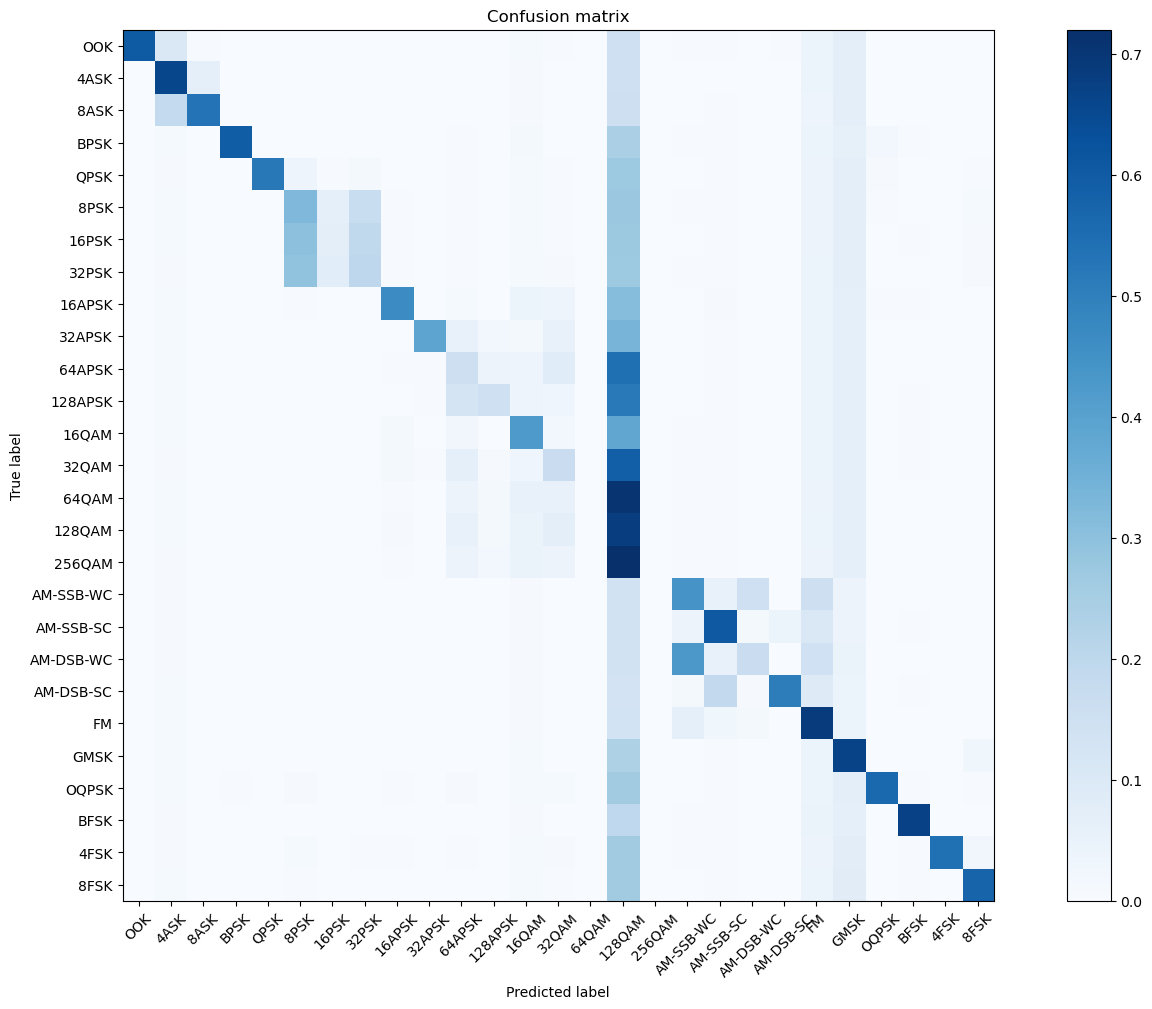

In [27]:
plot_confusion_matrix(confnorm, labels=classes)

In [28]:
test_Y_hat = model_1.predict(X_test, batch_size=batch_size)
conf = np.zeros([num_classes,num_classes])
confnorm = np.zeros([num_classes,num_classes])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,num_classes):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

281/281 [==============================] - 1s 4ms/step


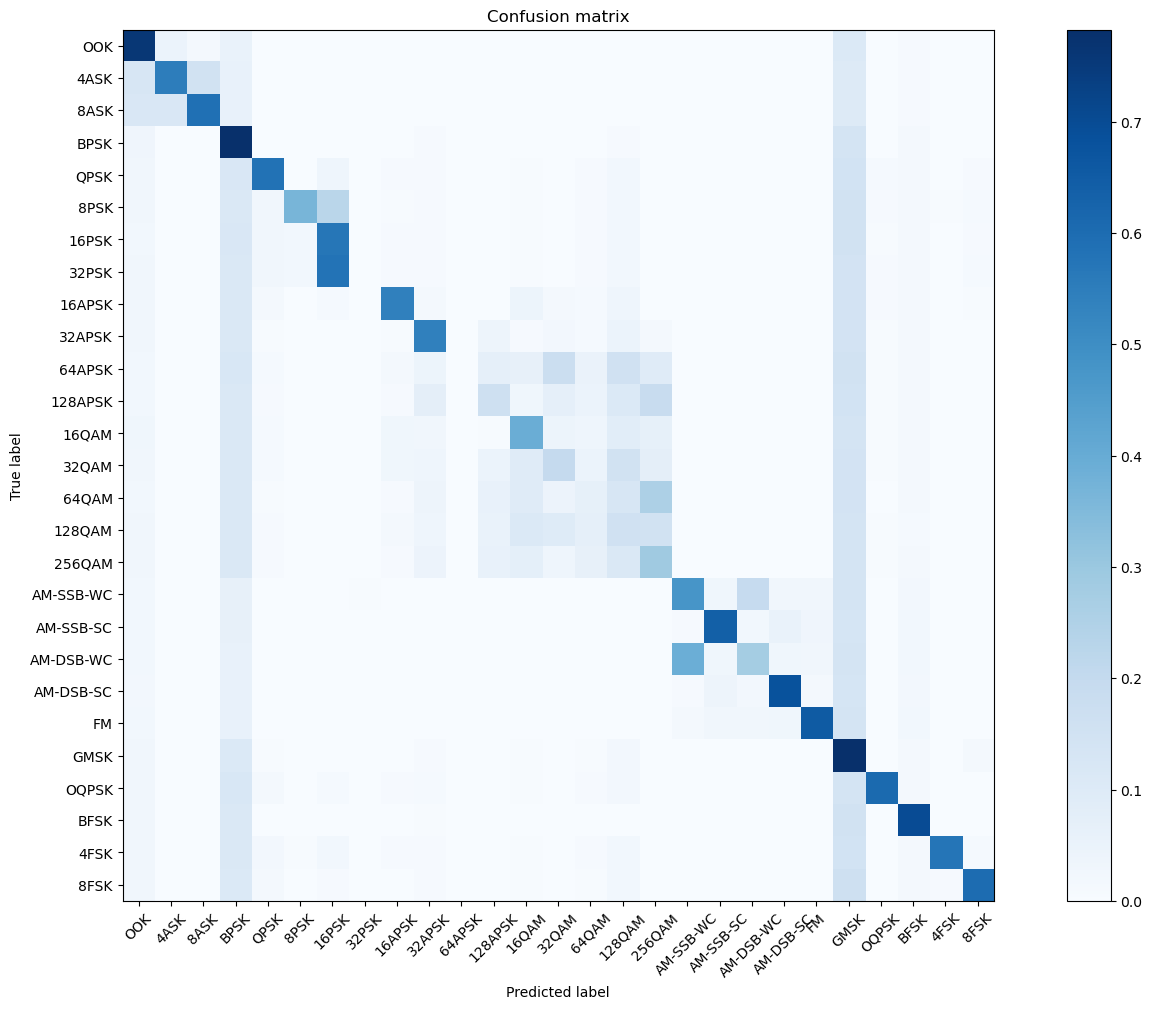

In [29]:
plot_confusion_matrix(confnorm, labels=classes)

In [30]:
test_Y_hat = model_2.predict(X_test, batch_size=batch_size)
conf = np.zeros([num_classes,num_classes])
confnorm = np.zeros([num_classes,num_classes])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,num_classes):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

281/281 [==============================] - 1s 4ms/step


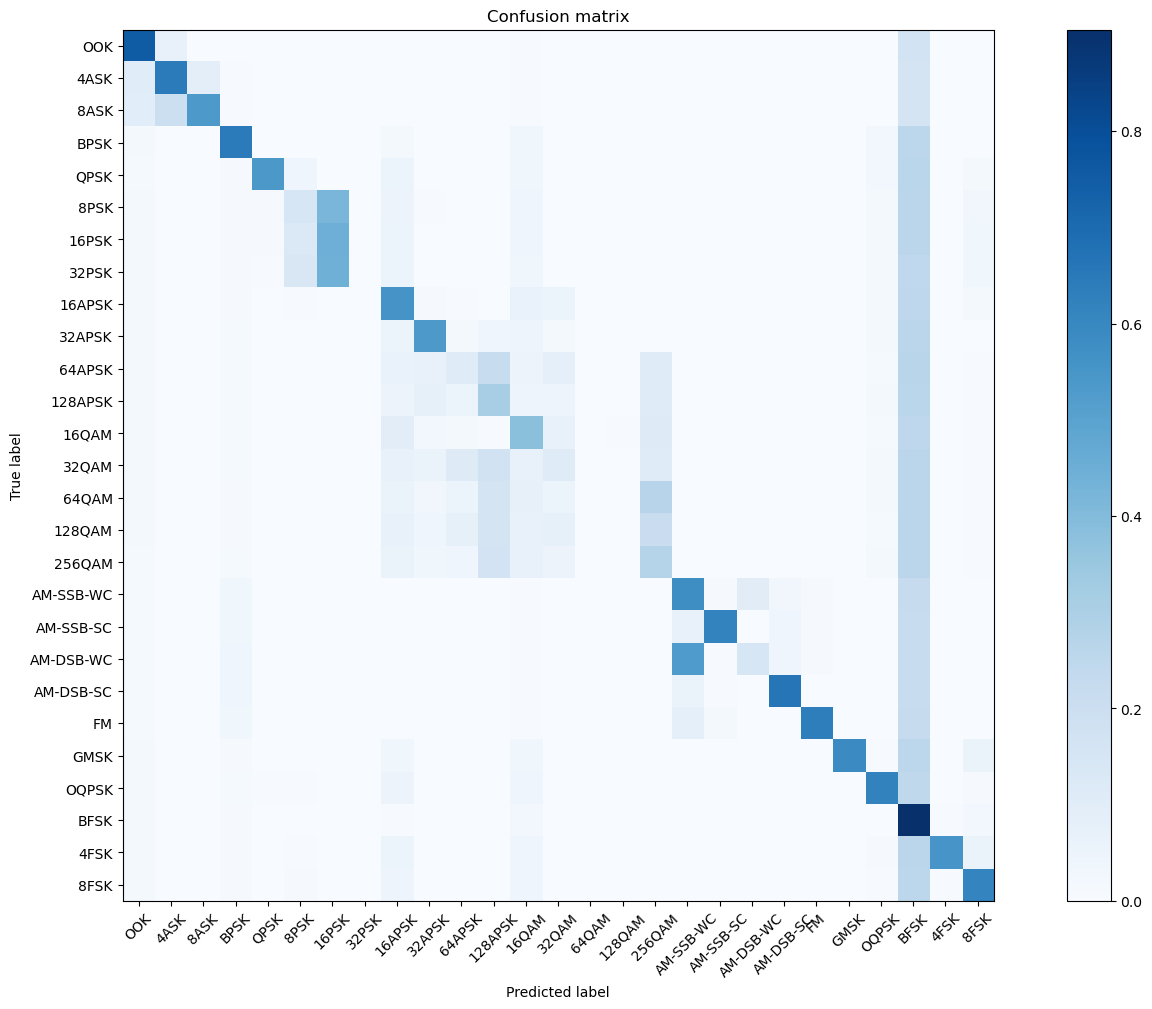

In [31]:
plot_confusion_matrix(confnorm, labels=classes)

### Generate Classification Report

In [32]:
Y_pred = model_0.predict(X_test,batch_size=batch_size)
y_pred = np.argmax(Y_pred, axis = 1)
y_actual = np.argmax(Y_test, axis = 1)
classificationreport_fp = classification_report(y_actual,y_pred, target_names=mods)
print(classificationreport_fp)

281/281 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

         OOK       1.00      0.60      0.75     10486
        4ASK       0.57      0.66      0.61     10721
        8ASK       0.88      0.53      0.66     10559
        BPSK       0.98      0.60      0.74     10512
        QPSK       0.99      0.52      0.68     10643
        8PSK       0.32      0.33      0.32     10804
       16PSK       0.33      0.07      0.12     10685
       32PSK       0.34      0.20      0.25     10688
      16APSK       0.86      0.46      0.60     10826
      32APSK       0.95      0.39      0.55     10664
      64APSK       0.25      0.15      0.19     10564
     128APSK       0.57      0.15      0.24     10730
       16QAM       0.48      0.42      0.45     10670
       32QAM       0.27      0.16      0.20     10633
       64QAM       0.00      0.00      0.00     10699
      128QAM       0.08      0.68      0.14     10673
      256QAM       0.50   

In [33]:
Y_pred = model_1.predict(X_test,batch_size=batch_size)
y_pred = np.argmax(Y_pred, axis = 1)
y_actual = np.argmax(Y_test, axis = 1)
classificationreport_fp = classification_report(y_actual,y_pred, target_names=mods)
print(classificationreport_fp)

281/281 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

         OOK       0.47      0.76      0.58     10486
        4ASK       0.75      0.55      0.63     10721
        8ASK       0.78      0.59      0.67     10559
        BPSK       0.23      0.78      0.36     10512
        QPSK       0.72      0.58      0.64     10643
        8PSK       0.83      0.37      0.51     10804
       16PSK       0.39      0.57      0.46     10685
       32PSK       0.02      0.00      0.00     10688
      16APSK       0.78      0.54      0.64     10826
      32APSK       0.58      0.54      0.56     10664
      64APSK       0.00      0.00      0.00     10564
     128APSK       0.32      0.16      0.21     10730
       16QAM       0.41      0.39      0.40     10670
       32QAM       0.28      0.20      0.23     10633
       64QAM       0.14      0.07      0.09     10699
      128QAM       0.13      0.15      0.14     10673
      256QAM       0.25   

/opt/vitis_ai/conda/envs/vitis-ai-tensorflow2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/vitis_ai/conda/envs/vitis-ai-tensorflow2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/vitis_ai/conda/envs/vitis-ai-tensorflow2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [34]:
Y_pred = model_2.predict(X_test,batch_size=batch_size)
y_pred = np.argmax(Y_pred, axis = 1)
y_actual = np.argmax(Y_test, axis = 1)
classificationreport_fp = classification_report(y_actual,y_pred, target_names=mods)
print(classificationreport_fp)

281/281 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

         OOK       0.56      0.75      0.64     10486
        4ASK       0.71      0.64      0.67     10721
        8ASK       0.85      0.54      0.66     10559
        BPSK       0.63      0.64      0.64     10512
        QPSK       0.95      0.54      0.69     10643
        8PSK       0.31      0.15      0.20     10804
       16PSK       0.34      0.45      0.39     10685
       32PSK       0.00      0.00      0.00     10688
      16APSK       0.38      0.55      0.45     10826
      32APSK       0.59      0.54      0.56     10664
      64APSK       0.22      0.11      0.15     10564
     128APSK       0.26      0.31      0.28     10730
       16QAM       0.31      0.38      0.34     10670
       32QAM       0.19      0.11      0.14     10633
       64QAM       0.00      0.00      0.00     10699
      128QAM       0.15      0.00      0.00     10673
      256QAM       0.23   

/opt/vitis_ai/conda/envs/vitis-ai-tensorflow2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/vitis_ai/conda/envs/vitis-ai-tensorflow2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/vitis_ai/conda/envs/vitis-ai-tensorflow2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Precision Measures the  Accuracy of the positive predictions.
Precision = TP/(TP + FP)

Recall Measures the fraction of positives that were correctly identified.
Recall = TP/(TP+FN)

The F1 score is measure of a weighted harmonic mean of precision and recall. 

Support is the number of values for each class.

Looking at the f1- scores for the different classes, we can see that the model is more accuracte with some classses than others.
For example, the model is not able to correctly identify the hiher order PSK and QAM modulations as other classes.   

### Accuracy vs. SNR
Now lets see how the model accuracy is effcted by SNR.

In [35]:
batchsize = 1024
progress = ProgressBar()
snrlist = np.unique(Z_test)
acc_snr_arr = []

# interate over SNRs
for snr in progress(snrlist):
    acc_arr = []
    i_SNR = np.where(Z_test==snr)
    X_SNR = X_test[i_SNR[0],:,:]
    Y_SNR = Y_test[i_SNR[0],:]
    X_SNR_len = np.shape(X_SNR)[0]
    total_batches = int(X_SNR_len/batchsize)
    
    for i in (range(0, total_batches)):
        x_batch, y_batch = X_SNR[i*batchsize:i*batchsize+batchsize], Y_SNR[i*batchsize:i*batchsize+batchsize]
        
        # model prediction
        pred = model_0.predict(x_batch)
        
        #Pediction values are onehote, corresponding to indices representing different modulation types
        pred_ind = np.argmax(pred, axis=1)
        expected_ind = np.argmax(y_batch, axis=1)
        matches  = sum(np.equal(pred_ind, expected_ind))
        acc      = matches/batchsize
        acc_arr.append(acc)

    # Average the per-batch accuracy values
    accuracy = np.mean(acc_arr)
    acc_snr_arr.append(accuracy)
    print("SNR: ", snr, "accuracy", accuracy)

  0% |                                                                                                                                                                                       |

32/32 [==============================] - 0s 405us/step


  3% |#######                                                                                                                                                                                |

SNR:  -20 accuracy 0.03466796875
32/32 [==============================] - 0s 397us/step


  7% |##############                                                                                                                                                                         |

SNR:  -18 accuracy 0.037109375
32/32 [==============================] - 0s 415us/step


 11% |#####################                                                                                                                                                                  |

SNR:  -16 accuracy 0.0359375
32/32 [==============================] - 0s 416us/step


 15% |############################                                                                                                                                                           |

SNR:  -14 accuracy 0.03837890625
32/32 [==============================] - 0s 409us/step


 19% |###################################                                                                                                                                                    |

SNR:  -12 accuracy 0.04091796875
32/32 [==============================] - 0s 407us/step


 23% |##########################################                                                                                                                                             |

SNR:  -10 accuracy 0.0462890625
32/32 [==============================] - 0s 402us/step


 26% |#################################################                                                                                                                                      |

SNR:  -8 accuracy 0.0568359375
32/32 [==============================] - 0s 432us/step


 30% |########################################################                                                                                                                               |

SNR:  -6 accuracy 0.0888671875
32/32 [==============================] - 0s 400us/step


 34% |###############################################################                                                                                                                        |

SNR:  -4 accuracy 0.14375
32/32 [==============================] - 0s 406us/step


 38% |######################################################################                                                                                                                 |

SNR:  -2 accuracy 0.19462890625
32/32 [==============================] - 0s 428us/step


 42% |#############################################################################                                                                                                          |

SNR:  0 accuracy 0.28583984375
32/32 [==============================] - 0s 396us/step


 46% |####################################################################################                                                                                                   |

SNR:  2 accuracy 0.423828125
32/32 [==============================] - 0s 406us/step


 50% |###########################################################################################                                                                                            |

SNR:  4 accuracy 0.53984375
32/32 [==============================] - 0s 393us/step


 53% |##################################################################################################                                                                                     |

SNR:  6 accuracy 0.6255859375
32/32 [==============================] - 0s 387us/step


 57% |#########################################################################################################                                                                              |

SNR:  8 accuracy 0.6734375
32/32 [==============================] - 0s 397us/step


 61% |################################################################################################################                                                                       |

SNR:  10 accuracy 0.67998046875
32/32 [==============================] - 0s 404us/step


 65% |#######################################################################################################################                                                                |

SNR:  12 accuracy 0.69716796875
32/32 [==============================] - 0s 441us/step


 69% |##############################################################################################################################                                                         |

SNR:  14 accuracy 0.70224609375
32/32 [==============================] - 0s 424us/step


 73% |#####################################################################################################################################                                                  |

SNR:  16 accuracy 0.688671875
32/32 [==============================] - 0s 404us/step


 76% |############################################################################################################################################                                           |

SNR:  18 accuracy 0.69365234375
32/32 [==============================] - 0s 547us/step


 80% |###################################################################################################################################################                                    |

SNR:  20 accuracy 0.6974609375
32/32 [==============================] - 0s 436us/step


 84% |##########################################################################################################################################################                             |

SNR:  22 accuracy 0.6953125
32/32 [==============================] - 0s 467us/step


 88% |#################################################################################################################################################################                      |

SNR:  24 accuracy 0.69423828125
32/32 [==============================] - 0s 434us/step


 92% |########################################################################################################################################################################               |

SNR:  26 accuracy 0.70078125
32/32 [==============================] - 0s 387us/step


 96% |###############################################################################################################################################################################        |

SNR:  28 accuracy 0.70224609375
32/32 [==============================] - 0s 381us/step


100% |#######################################################################################################################################################################################|

SNR:  30 accuracy 0.69775390625


<Figure size 100x100 with 0 Axes>

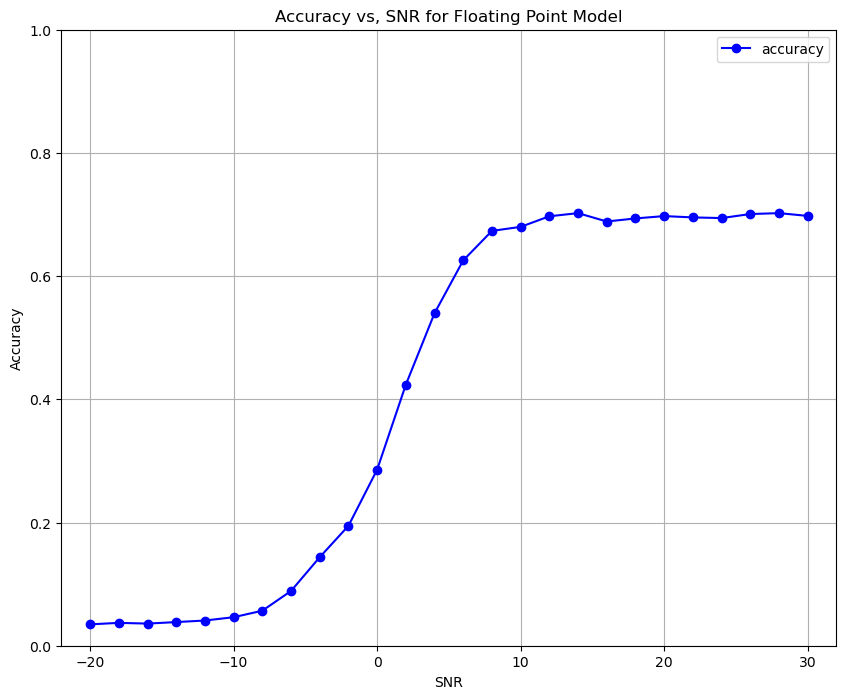

In [36]:
plt.figure(figsize=(1,1))
plt.show()
fig= plt.figure(figsize=(10,8))
plt.plot(snrlist, acc_snr_arr, 'bo-', label='accuracy')
plt.ylabel('Accuracy')
plt.xlabel('SNR')
plt.title("Accuracy vs, SNR for Floating Point Model")
plt.legend()
plt.axis([-22, 32, 0, 1.0])
plt.grid()

In [37]:
batchsize = 1024
progress = ProgressBar()
snrlist = np.unique(Z_test)
acc_snr_arr = []

# interate over SNRs
for snr in progress(snrlist):
    acc_arr = []
    i_SNR = np.where(Z_test==snr)
    X_SNR = X_test[i_SNR[0],:,:]
    Y_SNR = Y_test[i_SNR[0],:]
    X_SNR_len = np.shape(X_SNR)[0]
    total_batches = int(X_SNR_len/batchsize)
    
    for i in (range(0, total_batches)):
        x_batch, y_batch = X_SNR[i*batchsize:i*batchsize+batchsize], Y_SNR[i*batchsize:i*batchsize+batchsize]
        
        # model prediction
        pred = model_1.predict(x_batch)
        
        #Pediction values are onehote, corresponding to indices representing different modulation types
        pred_ind = np.argmax(pred, axis=1)
        expected_ind = np.argmax(y_batch, axis=1)
        matches  = sum(np.equal(pred_ind, expected_ind))
        acc      = matches/batchsize
        acc_arr.append(acc)

    # Average the per-batch accuracy values
    accuracy = np.mean(acc_arr)
    acc_snr_arr.append(accuracy)
    print("SNR: ", snr, "accuracy", accuracy)

  0% |                                                                                                                                                                                       |

32/32 [==============================] - 0s 445us/step


  3% |#######                                                                                                                                                                                |

SNR:  -20 accuracy 0.03720703125
32/32 [==============================] - 0s 440us/step


  7% |##############                                                                                                                                                                         |

SNR:  -18 accuracy 0.0369140625
32/32 [==============================] - 0s 494us/step


 11% |#####################                                                                                                                                                                  |

SNR:  -16 accuracy 0.03876953125
32/32 [==============================] - 0s 511us/step


 15% |############################                                                                                                                                                           |

SNR:  -14 accuracy 0.0392578125
32/32 [==============================] - 0s 513us/step


 19% |###################################                                                                                                                                                    |

SNR:  -12 accuracy 0.04599609375
32/32 [==============================] - 0s 488us/step


 23% |##########################################                                                                                                                                             |

SNR:  -10 accuracy 0.0576171875
32/32 [==============================] - 0s 449us/step


 26% |#################################################                                                                                                                                      |

SNR:  -8 accuracy 0.0857421875
32/32 [==============================] - 0s 464us/step


 30% |########################################################                                                                                                                               |

SNR:  -6 accuracy 0.12333984375
32/32 [==============================] - 0s 510us/step


 34% |###############################################################                                                                                                                        |

SNR:  -4 accuracy 0.1771484375
32/32 [==============================] - 0s 417us/step


 38% |######################################################################                                                                                                                 |

SNR:  -2 accuracy 0.31630859375
32/32 [==============================] - 0s 428us/step


 42% |#############################################################################                                                                                                          |

SNR:  0 accuracy 0.45859375
32/32 [==============================] - 0s 422us/step


 46% |####################################################################################                                                                                                   |

SNR:  2 accuracy 0.58125
32/32 [==============================] - 0s 430us/step


 50% |###########################################################################################                                                                                            |

SNR:  4 accuracy 0.65830078125
32/32 [==============================] - 0s 464us/step


 53% |##################################################################################################                                                                                     |

SNR:  6 accuracy 0.69541015625
32/32 [==============================] - 0s 526us/step


 57% |#########################################################################################################                                                                              |

SNR:  8 accuracy 0.71640625
32/32 [==============================] - 0s 465us/step


 61% |################################################################################################################                                                                       |

SNR:  10 accuracy 0.72265625
32/32 [==============================] - 0s 536us/step


 65% |#######################################################################################################################                                                                |

SNR:  12 accuracy 0.729296875
32/32 [==============================] - 0s 462us/step


 69% |##############################################################################################################################                                                         |

SNR:  14 accuracy 0.7263671875
32/32 [==============================] - 0s 446us/step


 73% |#####################################################################################################################################                                                  |

SNR:  16 accuracy 0.7263671875
32/32 [==============================] - 0s 510us/step


 76% |############################################################################################################################################                                           |

SNR:  18 accuracy 0.72255859375
32/32 [==============================] - 0s 442us/step


 80% |###################################################################################################################################################                                    |

SNR:  20 accuracy 0.71865234375
32/32 [==============================] - 0s 433us/step


 84% |##########################################################################################################################################################                             |

SNR:  22 accuracy 0.72626953125
32/32 [==============================] - 0s 437us/step


 88% |#################################################################################################################################################################                      |

SNR:  24 accuracy 0.72109375
32/32 [==============================] - 0s 503us/step


 92% |########################################################################################################################################################################               |

SNR:  26 accuracy 0.72412109375
32/32 [==============================] - 0s 481us/step


 96% |###############################################################################################################################################################################        |

SNR:  28 accuracy 0.7283203125
32/32 [==============================] - 0s 433us/step


100% |#######################################################################################################################################################################################|

SNR:  30 accuracy 0.72578125


<Figure size 100x100 with 0 Axes>

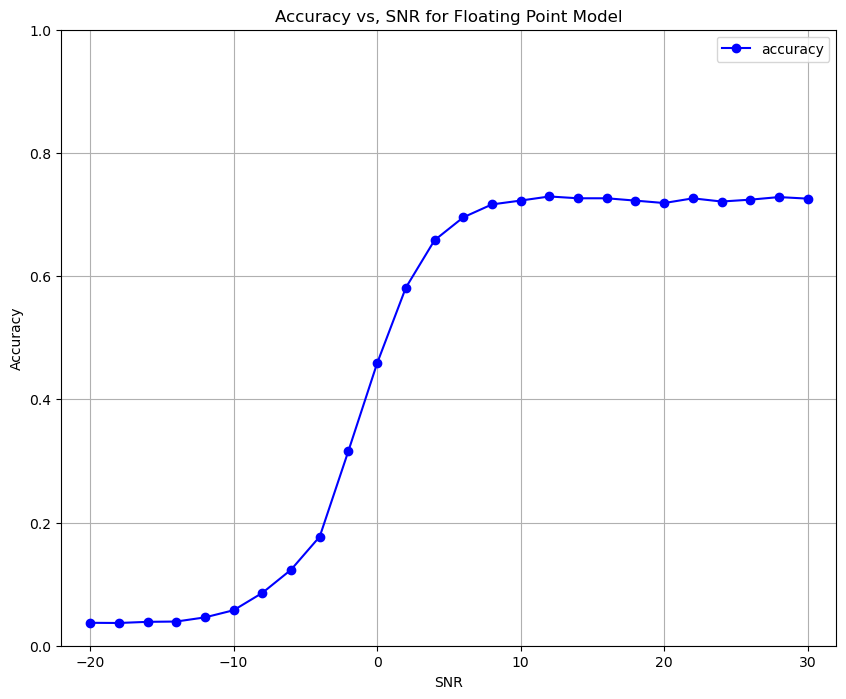

In [38]:
plt.figure(figsize=(1,1))
plt.show()
fig= plt.figure(figsize=(10,8))
plt.plot(snrlist, acc_snr_arr, 'bo-', label='accuracy')
plt.ylabel('Accuracy')
plt.xlabel('SNR')
plt.title("Accuracy vs, SNR for Floating Point Model")
plt.legend()
plt.axis([-22, 32, 0, 1.0])
plt.grid()

In [39]:
batchsize = 1024
progress = ProgressBar()
snrlist = np.unique(Z_test)
acc_snr_arr = []

# interate over SNRs
for snr in progress(snrlist):
    acc_arr = []
    i_SNR = np.where(Z_test==snr)
    X_SNR = X_test[i_SNR[0],:,:]
    Y_SNR = Y_test[i_SNR[0],:]
    X_SNR_len = np.shape(X_SNR)[0]
    total_batches = int(X_SNR_len/batchsize)
    
    for i in (range(0, total_batches)):
        x_batch, y_batch = X_SNR[i*batchsize:i*batchsize+batchsize], Y_SNR[i*batchsize:i*batchsize+batchsize]
        
        # model prediction
        pred = model_2.predict(x_batch)
        
        #Pediction values are onehote, corresponding to indices representing different modulation types
        pred_ind = np.argmax(pred, axis=1)
        expected_ind = np.argmax(y_batch, axis=1)
        matches  = sum(np.equal(pred_ind, expected_ind))
        acc      = matches/batchsize
        acc_arr.append(acc)

    # Average the per-batch accuracy values
    accuracy = np.mean(acc_arr)
    acc_snr_arr.append(accuracy)
    print("SNR: ", snr, "accuracy", accuracy)

  0% |                                                                                                                                                                                       |

32/32 [==============================] - 0s 429us/step


  3% |#######                                                                                                                                                                                |

SNR:  -20 accuracy 0.03701171875
32/32 [==============================] - 0s 460us/step


  7% |##############                                                                                                                                                                         |

SNR:  -18 accuracy 0.0375
32/32 [==============================] - 0s 563us/step


 11% |#####################                                                                                                                                                                  |

SNR:  -16 accuracy 0.03603515625
32/32 [==============================] - 0s 458us/step


 15% |############################                                                                                                                                                           |

SNR:  -14 accuracy 0.04140625
32/32 [==============================] - 0s 475us/step


 19% |###################################                                                                                                                                                    |

SNR:  -12 accuracy 0.04443359375
32/32 [==============================] - 0s 451us/step


 23% |##########################################                                                                                                                                             |

SNR:  -10 accuracy 0.05986328125
32/32 [==============================] - 0s 435us/step


 26% |#################################################                                                                                                                                      |

SNR:  -8 accuracy 0.07890625
32/32 [==============================] - 0s 437us/step


 30% |########################################################                                                                                                                               |

SNR:  -6 accuracy 0.13681640625
32/32 [==============================] - 0s 465us/step


 34% |###############################################################                                                                                                                        |

SNR:  -4 accuracy 0.1755859375
32/32 [==============================] - 0s 447us/step


 38% |######################################################################                                                                                                                 |

SNR:  -2 accuracy 0.23115234375
32/32 [==============================] - 0s 432us/step


 42% |#############################################################################                                                                                                          |

SNR:  0 accuracy 0.390625
32/32 [==============================] - 0s 467us/step


 46% |####################################################################################                                                                                                   |

SNR:  2 accuracy 0.522265625
32/32 [==============================] - 0s 455us/step


 50% |###########################################################################################                                                                                            |

SNR:  4 accuracy 0.61669921875
32/32 [==============================] - 0s 440us/step


 53% |##################################################################################################                                                                                     |

SNR:  6 accuracy 0.6595703125
32/32 [==============================] - 0s 432us/step


 57% |#########################################################################################################                                                                              |

SNR:  8 accuracy 0.690234375
32/32 [==============================] - 0s 542us/step


 61% |################################################################################################################                                                                       |

SNR:  10 accuracy 0.6896484375
32/32 [==============================] - 0s 483us/step


 65% |#######################################################################################################################                                                                |

SNR:  12 accuracy 0.6970703125
32/32 [==============================] - 0s 450us/step


 69% |##############################################################################################################################                                                         |

SNR:  14 accuracy 0.70205078125
32/32 [==============================] - 0s 532us/step


 73% |#####################################################################################################################################                                                  |

SNR:  16 accuracy 0.6947265625
32/32 [==============================] - 0s 432us/step


 76% |############################################################################################################################################                                           |

SNR:  18 accuracy 0.6943359375
32/32 [==============================] - 0s 477us/step


 80% |###################################################################################################################################################                                    |

SNR:  20 accuracy 0.69365234375
32/32 [==============================] - 0s 430us/step


 84% |##########################################################################################################################################################                             |

SNR:  22 accuracy 0.6951171875
32/32 [==============================] - 0s 622us/step


 88% |#################################################################################################################################################################                      |

SNR:  24 accuracy 0.70185546875
32/32 [==============================] - 0s 455us/step


 92% |########################################################################################################################################################################               |

SNR:  26 accuracy 0.6955078125
32/32 [==============================] - 0s 434us/step


 96% |###############################################################################################################################################################################        |

SNR:  28 accuracy 0.70087890625
32/32 [==============================] - 0s 449us/step


100% |#######################################################################################################################################################################################|

SNR:  30 accuracy 0.69765625


<Figure size 100x100 with 0 Axes>

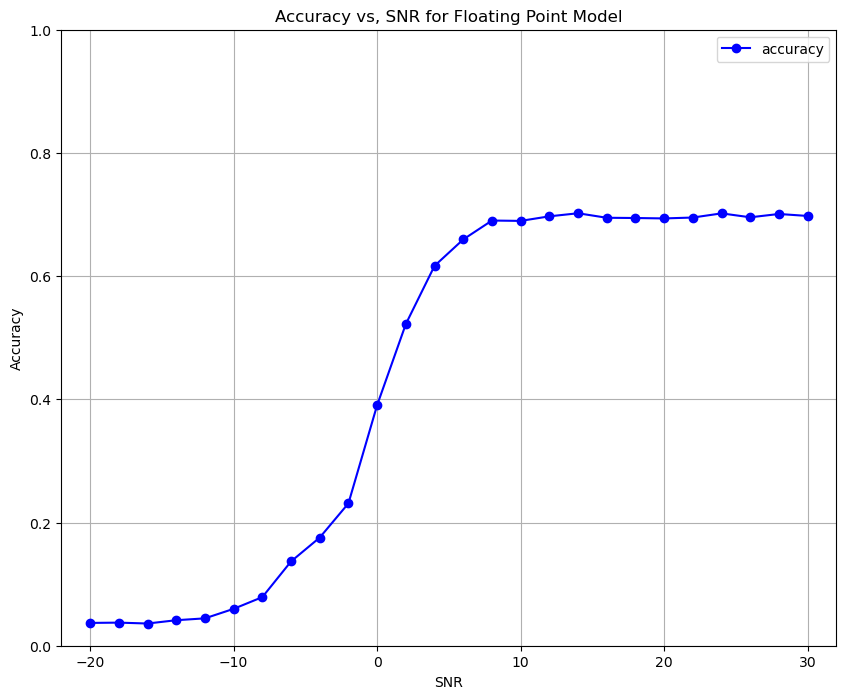

In [40]:
plt.figure(figsize=(1,1))
plt.show()
fig= plt.figure(figsize=(10,8))
plt.plot(snrlist, acc_snr_arr, 'bo-', label='accuracy')
plt.ylabel('Accuracy')
plt.xlabel('SNR')
plt.title("Accuracy vs, SNR for Floating Point Model")
plt.legend()
plt.axis([-22, 32, 0, 1.0])
plt.grid()

Are you can see for SNRs below -10db the Top1 accuracy is no better than a random guess (1/27), and once SNR is above 10db the Top1 accuracy approaches 98%.

## Vitis AI
The Vitis-AI tools will be used the Quantize and Compile the model for accleration on the DPU. <br>
Vitis-AI 2.0 natively supports keras in TensorFlow2, and we can directly read in the .h5 model. 

## Quantize Model to INT8
The Vitis-AI Quantizer uses a  small set of unlabeled samples to analyze the distribution of the activations. We will use 1000 input samples from the test set. <br>

The quantized.h5 model that is produced will be used as input to the Vitis-AI Quantizer

In [19]:
X_test_calib, Y_test_calib = get_balanced_snr_samples(X_test, Y_test, Z_test, samples_per_snr=40, seed=0)

print(np.shape(X_test_calib))
print(np.shape(Y_test_calib))

(1040, 1024, 1, 2)
(1040, 27)


In [32]:
model = tf.keras.models.load_model("resnet_checkpoints/best_keras_model.keras")

In [33]:
from tensorflow_model_optimization.quantization.keras import vitis_quantize

quantizer = vitis_quantize.VitisQuantizer(model)
quantized_model = quantizer.quantize_model(calib_dataset = X_train[1:1000])

# Save the model
!mkdir -p quantize_results
quantized_model.save('resnet_checkpoints/baseline_model_quantized.h5')
!ls -l quantize_results

[VAI INFO] Using func format quantizer
[VAI INFO] Quantizing without specific `target`.
[VAI INFO] Start CrossLayerEqualization...
10/10 [==============================] - 0s 54ms/step
[VAI INFO] CrossLayerEqualization Done.


ValueError: Cannot assign value to variable ' batch_normalization/depthwise_kernel:0': Shape mismatch.The variable shape (1, 1, 32, 1), and the assigned value shape (1, 1, 64, 1) are incompatible.

In [41]:
with vitis_quantize.quantize_scope():
  q_model = tf.keras.models.load_model('resnet_checkpoints/model_2_relu_no_bn_no_fft.h5', compile=False)

q_model.compile(loss='categorical_crossentropy', metrics=["accuracy"])
q_model.evaluate(X_test, Y_test,  verbose=0, batch_size=batch_size)

[2.334228038787842, 0.3063226044178009]

In [42]:
with vitis_quantize.quantize_scope():
  q_model = tf.keras.models.load_model('resnet_checkpoints/model_2_relu_no_bn_no_fft.h5', compile=False)

q_model.compile(loss='categorical_crossentropy', metrics=["accuracy"])
q_model.evaluate(X_best_test, Y_best_test,  verbose=0, batch_size=batch_size)

[1.6349101066589355, 0.4724695682525635]

In [29]:
from tensorflow_model_optimization.quantization.keras import vitis_quantize
quantizer = vitis_quantize.VitisQuantizer(model_1)
quantized_model = quantizer.quantize_model(calib_dataset = X_test[1:1000])

# Save the model
!mkdir -p quantize_results
quantized_model.save('resnet_checkpoints/model_1_relu_100ep_nofft.h5')
!ls -l quantize_results

[VAI INFO] Using func format quantizer
[VAI INFO] Quantizing without specific `target`.
[VAI INFO] Start CrossLayerEqualization...
10/10 [==============================] - 1s 95ms/step
[VAI INFO] CrossLayerEqualization Done.
[VAI INFO] Start Quantize Calibration...
32/32 [==============================] - 2s 10ms/step
[VAI INFO] Quantize Calibration Done.
[VAI INFO] Start Post-Quant Model Refinement...
[VAI INFO] Start Quantize Position Ajustment...
[VAI INFO] Quantize Position Ajustment Done.
[VAI INFO] Post-Quant Model Refninement Done.
[VAI INFO] Start Model Finalization...
[VAI INFO] Model Finalization Done.
[VAI INFO] Quantization Finished.
total 0


In [30]:
from tensorflow_model_optimization.quantization.keras import vitis_quantize
quantizer = vitis_quantize.VitisQuantizer(model_2)
quantized_model = quantizer.quantize_model(calib_dataset = X_test[1:1000])

# Save the model
!mkdir -p quantize_results
quantized_model.save('resnet_checkpoints/model_2_relu_100ep_quantized_nofft.h5')
!ls -l quantize_results

[VAI INFO] Using func format quantizer
[VAI INFO] Quantizing without specific `target`.
[VAI INFO] Start CrossLayerEqualization...
10/10 [==============================] - 1s 86ms/step
[VAI INFO] CrossLayerEqualization Done.
[VAI INFO] Start Quantize Calibration...
32/32 [==============================] - 2s 11ms/step
[VAI INFO] Quantize Calibration Done.
[VAI INFO] Start Post-Quant Model Refinement...
[VAI INFO] Start Quantize Position Ajustment...
[VAI INFO] Quantize Position Ajustment Done.
[VAI INFO] Post-Quant Model Refninement Done.
[VAI INFO] Start Model Finalization...
[VAI INFO] Model Finalization Done.
[VAI INFO] Quantization Finished.
total 0


### Load and Compile Model for Evaluation
We can now load and recompile the INT8 model and run evaluations to compare with the floating point model

### Evalute  Model INT8 Performance

In [14]:
# load quantized model
from tensorflow_model_optimization.quantization.keras import vitis_quantize
with vitis_quantize.quantize_scope():
  q_model = tf.keras.models.load_model('resnet_checkpoints/model_0_relu_sep_activation_no_bn_no_fft.h5', compile=False)

q_model.compile(loss='categorical_crossentropy', metrics=["accuracy"])

score = q_model.evaluate(X_test, Y_test,  verbose=0, batch_size=1024)
print(score)

[8.225412368774414, 0.1566251665353775]


In [32]:
# load quantized model
from tensorflow_model_optimization.quantization.keras import vitis_quantize
with vitis_quantize.quantize_scope():
  q_model = tf.keras.models.load_model('resnet_checkpoints/model_0_relu_quantized_nofft.h5', compile=False)

q_model.compile(loss='categorical_crossentropy', metrics=["accuracy"])

score = q_model.evaluate(X_best_test, Y_best_test,  verbose=0, batch_size=1024)
print(score)

[61.04332733154297, 0.03661639243364334]


In [33]:
# load quantized model
from tensorflow_model_optimization.quantization.keras import vitis_quantize
with vitis_quantize.quantize_scope():
  q_model = tf.keras.models.load_model('resnet_checkpoints/model_1_relu_100ep_nofft.h5', compile=False)

q_model.compile(loss='categorical_crossentropy', metrics=["accuracy"])

score = q_model.evaluate(X_test, Y_test,  verbose=0, batch_size=1024)
print(score)

[6.2557196617126465, 0.27334630489349365]


In [34]:
# load quantized model
from tensorflow_model_optimization.quantization.keras import vitis_quantize
with vitis_quantize.quantize_scope():
  q_model = tf.keras.models.load_model('resnet_checkpoints/model_1_relu_100ep_nofft.h5', compile=False)

q_model.compile(loss='categorical_crossentropy', metrics=["accuracy"])

score = q_model.evaluate(X_best_test, Y_best_test,  verbose=0, batch_size=1024)
print(score)

[3.9485223293304443, 0.4394875466823578]


In [36]:
# load quantized model
from tensorflow_model_optimization.quantization.keras import vitis_quantize
with vitis_quantize.quantize_scope():
  q_model = tf.keras.models.load_model('resnet_checkpoints/model_2_relu_100ep_quantized_nofft.h5', compile=False)

q_model.compile(loss='categorical_crossentropy', metrics=["accuracy"])

score = q_model.evaluate(X_test, Y_test,  verbose=0, batch_size=1024)
print(score)

[1843.3773193359375, 0.06748626381158829]


In [37]:
# load quantized model
from tensorflow_model_optimization.quantization.keras import vitis_quantize
with vitis_quantize.quantize_scope():
  q_model = tf.keras.models.load_model('resnet_checkpoints/model_2_relu_100ep_quantized_nofft.h5', compile=False)

q_model.compile(loss='categorical_crossentropy', metrics=["accuracy"])

score = q_model.evaluate(X_best_test, Y_best_test,  verbose=0, batch_size=1024)
print(score)

[1976.7515869140625, 0.08640741556882858]


In [39]:
q_model.fit(
    X_train,
    Y_train,
    epochs=100,
    validation_data=(X_test, Y_test),
    verbose=1,
    callbacks=
    [
        EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1)     
    ])

Epoch 1/100


KeyboardInterrupt: 

In [22]:
q_model.save('resnet_checkpoints/model_0_quantized.h5')

The Overall Top-1 score has gone down by about .4% due to quantization

### Classification Report for INT8 Model

In [29]:
from tensorflow_model_optimization.quantization.keras import vitis_quantize
with vitis_quantize.quantize_scope():
    q_model = tf.keras.models.load_model("resnet_checkpoints/model_2_relu_no_bn_fftv1.h5")

In [23]:
Y_pred = q_model.predict(X_usable_test,batch_size=1024)
y_pred = np.argmax(Y_pred, axis = 1)
y_actual = np.argmax(Y_usable_test, axis = 1)
classificationreport_int8 = classification_report(y_actual,y_pred, target_names=mods)
print(classificationreport_int8)

141/141 [==============================] - 2s 11ms/step
              precision    recall  f1-score   support

         OOK       0.89      0.98      0.93      5261
        4ASK       0.62      0.77      0.69      5468
        8ASK       0.81      0.55      0.65      5269
        BPSK       0.95      1.00      0.97      5282
        QPSK       0.60      0.88      0.71      5258
        8PSK       0.28      0.81      0.41      5304
       16PSK       0.00      0.00      0.00      5331
       32PSK       0.00      0.00      0.00      5423
      16APSK       0.15      0.82      0.25      5436
      32APSK       0.41      0.49      0.45      5350
      64APSK       0.12      0.03      0.05      5178
     128APSK       0.17      0.14      0.15      5327
       16QAM       0.16      0.13      0.14      5407
       32QAM       0.00      0.00      0.00      5311
       64QAM       0.00      0.00      0.00      5366
      128QAM       0.00      0.00      0.00      5312
      256QAM       0.20  

/opt/vitis_ai/conda/envs/vitis-ai-tensorflow2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/vitis_ai/conda/envs/vitis-ai-tensorflow2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/vitis_ai/conda/envs/vitis-ai-tensorflow2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [30]:
# Plot confusion matrix
test_Y_hat = q_model.predict(X_usable_test, batch_size=1024)
conf = np.zeros([num_classes,num_classes])
confnorm = np.zeros([num_classes,num_classes])
for i in range(0,X_usable_test.shape[0]):
    j = list(Y_usable_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,num_classes):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

141/141 [==============================] - 2s 11ms/step


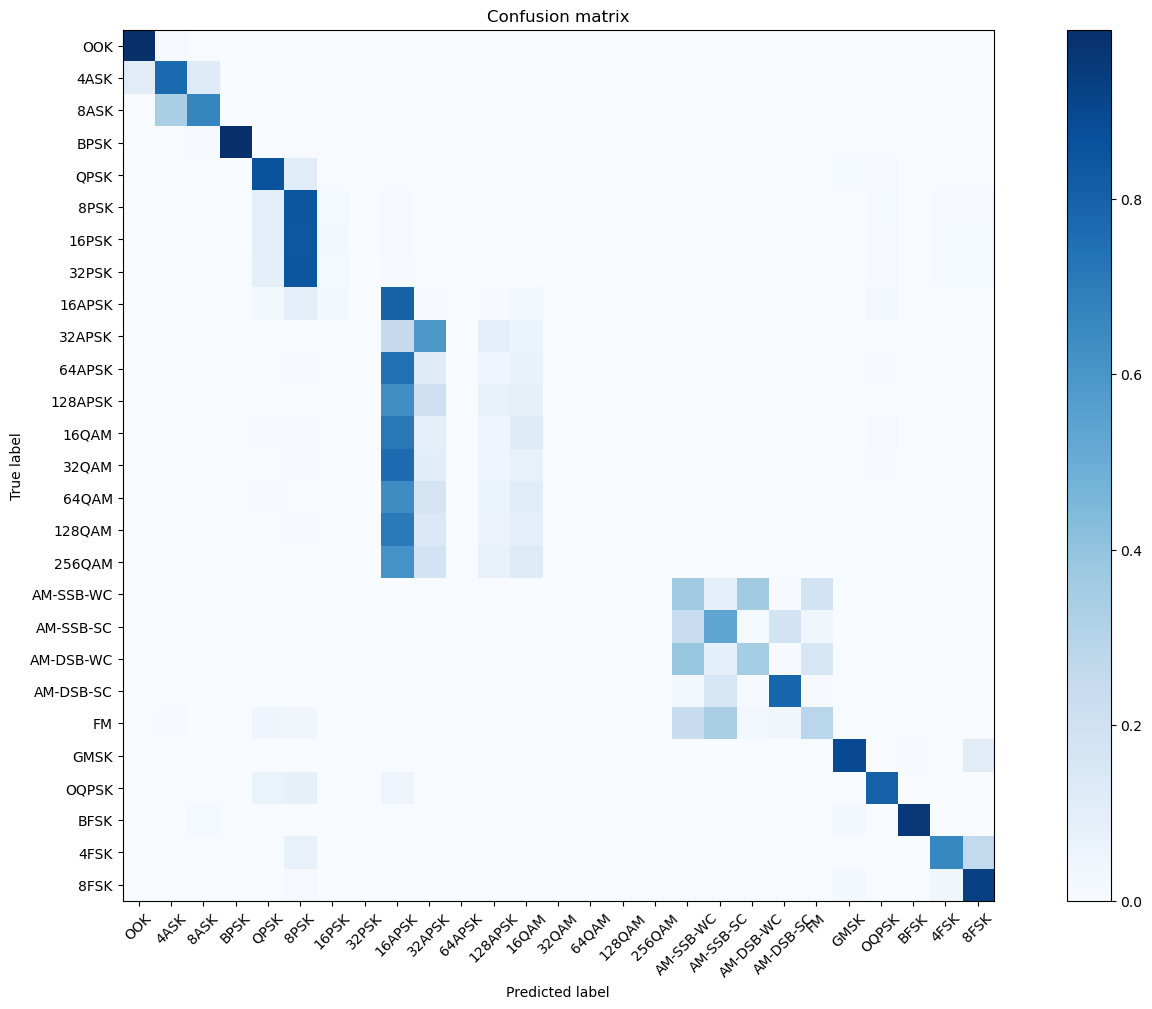

In [31]:
plot_confusion_matrix(confnorm, labels=classes)

### Accuracy vs SNR for INT8 Model

In [68]:
batchsize = 128
progress = ProgressBar()
snrlist = np.unique(Z_test)
acc_snr_arr = []

q_model = tf.keras.models.load_model("resnet_checkpoints/model_0_quantized.h5")

# interate over SNRs
for snr in progress(snrlist):
    acc_arr = []
    i_SNR = np.where(Z_test==snr)
    X_SNR = X_test[i_SNR[0],:,:]
    Y_SNR = Y_test[i_SNR[0],:]
    X_SNR_len = np.shape(X_SNR)[0]
    total_batches = int(X_SNR_len/batchsize)
    
    for i in (range(0, total_batches)):
        x_batch, y_batch = X_SNR[i*batchsize:i*batchsize+batchsize], Y_SNR[i*batchsize:i*batchsize+batchsize]
        
        # model prediction
        pred = q_model.predict(x_batch)
        
        #Pediction values are 0-24, corresponding to indices representing different modulation types
        pred_ind = np.argmax(pred, axis=1)
        expected_ind = np.argmax(y_batch, axis=1)
        matches  = sum(np.equal(pred_ind, expected_ind))
        acc      = matches/batchsize
        acc_arr.append(acc)

    # Average the per-batch accuracy values
    accuracy = np.mean(acc_arr)
    acc_snr_arr.append(accuracy)
    print("SNR: ", snr, "accuracy", accuracy)

  0% |                                                                                                                                                                                       |

4/4 [==============================] - 0s 1ms/step


  3% |#######                                                                                                                                                                                |

SNR:  -20 accuracy 0.03624636627906977
4/4 [==============================] - 0s 1ms/step


  7% |##############                                                                                                                                                                         |

SNR:  -18 accuracy 0.03651889534883721
4/4 [==============================] - 0s 772us/step


 11% |#####################                                                                                                                                                                  |

SNR:  -16 accuracy 0.03466235632183908
4/4 [==============================] - 0s 910us/step


 15% |############################                                                                                                                                                           |

SNR:  -14 accuracy 0.03433866279069767
4/4 [==============================] - 0s 1ms/step


 19% |###################################                                                                                                                                                    |

SNR:  -12 accuracy 0.03497456395348837
4/4 [==============================] - 0s 794us/step


 23% |##########################################                                                                                                                                             |

SNR:  -10 accuracy 0.03670058139534884
4/4 [==============================] - 0s 830us/step


 26% |#################################################                                                                                                                                      |

SNR:  -8 accuracy 0.03542877906976744
4/4 [==============================] - 0s 840us/step


 30% |########################################################                                                                                                                               |

SNR:  -6 accuracy 0.03768382352941176
4/4 [==============================] - 0s 1ms/step


 34% |###############################################################                                                                                                                        |

SNR:  -4 accuracy 0.036609738372093026
4/4 [==============================] - 0s 1ms/step


 38% |######################################################################                                                                                                                 |

SNR:  -2 accuracy 0.036791424418604654
4/4 [==============================] - 0s 868us/step


 42% |#############################################################################                                                                                                          |

SNR:  0 accuracy 0.036948529411764706
4/4 [==============================] - 0s 792us/step


 46% |####################################################################################                                                                                                   |

SNR:  2 accuracy 0.03933502906976744
4/4 [==============================] - 0s 1ms/step


 50% |###########################################################################################                                                                                            |

SNR:  4 accuracy 0.036609738372093026
4/4 [==============================] - 0s 1ms/step


 53% |##################################################################################################                                                                                     |

SNR:  6 accuracy 0.035701308139534885
4/4 [==============================] - 0s 840us/step


 57% |#########################################################################################################                                                                              |

SNR:  8 accuracy 0.03561046511627907
4/4 [==============================] - 0s 1ms/step


 61% |################################################################################################################                                                                       |

SNR:  10 accuracy 0.03888081395348837
4/4 [==============================] - 0s 852us/step


 65% |#######################################################################################################################                                                                |

SNR:  12 accuracy 0.03740808823529412
4/4 [==============================] - 0s 905us/step


 69% |##############################################################################################################################                                                         |

SNR:  14 accuracy 0.03621323529411765
4/4 [==============================] - 0s 1ms/step


 73% |#####################################################################################################################################                                                  |

SNR:  16 accuracy 0.0369073275862069
4/4 [==============================] - 0s 809us/step


 76% |############################################################################################################################################                                           |

SNR:  18 accuracy 0.03624636627906977
4/4 [==============================] - 0s 874us/step


 80% |###################################################################################################################################################                                    |

SNR:  20 accuracy 0.03373161764705882
4/4 [==============================] - 0s 821us/step


 84% |##########################################################################################################################################################                             |

SNR:  22 accuracy 0.03621323529411765
4/4 [==============================] - 0s 908us/step


 88% |#################################################################################################################################################################                      |

SNR:  24 accuracy 0.035519622093023256
4/4 [==============================] - 0s 791us/step


 92% |########################################################################################################################################################################               |

SNR:  26 accuracy 0.03609913793103448
4/4 [==============================] - 0s 799us/step


 96% |###############################################################################################################################################################################        |

SNR:  28 accuracy 0.0404992816091954
4/4 [==============================] - 0s 1ms/step


100% |#######################################################################################################################################################################################|

SNR:  30 accuracy 0.03676470588235294


SNR:  26 accuracy 0.03672772988505747
4/4 [==============================] - 0s 848us/step


SNR:  28 accuracy 0.03865606936416185
4/4 [==============================] - 0s 919us/step


SNR:  30 accuracy 0.03654970760233918


<Figure size 100x100 with 0 Axes>

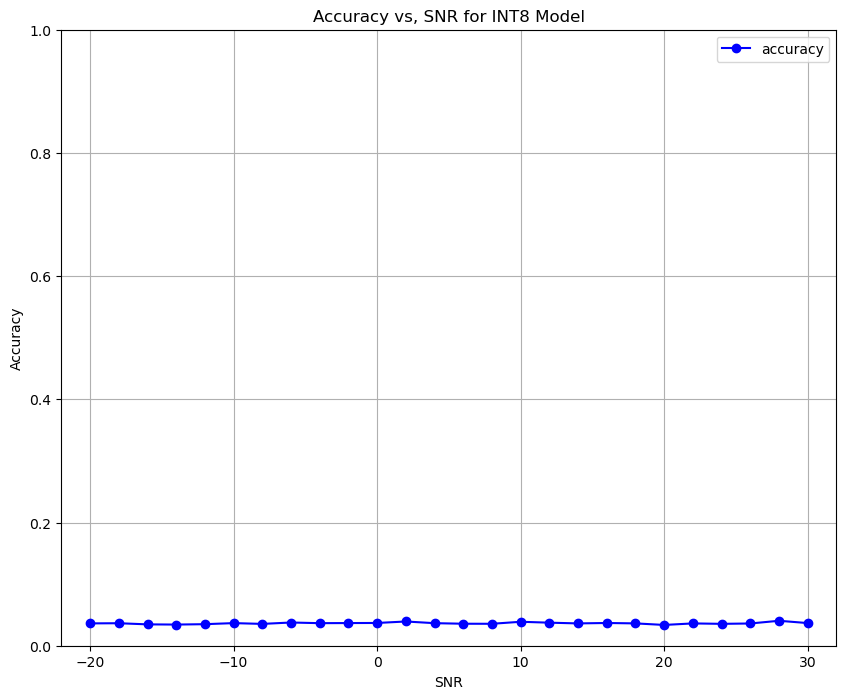

In [69]:
plt.figure(figsize=(1,1))
plt.show()
fig= plt.figure(figsize=(10,8))
plt.plot(snrlist, acc_snr_arr, 'bo-', label='accuracy')
plt.ylabel('Accuracy')
plt.xlabel('SNR')
plt.title("Accuracy vs, SNR for INT8 Model")
plt.legend()
plt.axis([-22, 32, 0, 1.0])
plt.grid()

In [38]:
batchsize = 128
progress = ProgressBar()
snrlist = np.unique(Z_test)
acc_snr_arr = []

q_model = tf.keras.models.load_model("resnet_checkpoints/model_1_relu_100ep_fftv2.h5")

# interate over SNRs
for snr in progress(snrlist):
    acc_arr = []
    i_SNR = np.where(Z_test==snr)
    X_SNR = X_test[i_SNR[0],:,:]
    Y_SNR = Y_test[i_SNR[0],:]
    X_SNR_len = np.shape(X_SNR)[0]
    total_batches = int(X_SNR_len/batchsize)
    
    for i in (range(0, total_batches)):
        x_batch, y_batch = X_SNR[i*batchsize:i*batchsize+batchsize], Y_SNR[i*batchsize:i*batchsize+batchsize]
        
        # model prediction
        pred = q_model.predict(x_batch)
        
        #Pediction values are 0-24, corresponding to indices representing different modulation types
        pred_ind = np.argmax(pred, axis=1)
        expected_ind = np.argmax(y_batch, axis=1)
        matches  = sum(np.equal(pred_ind, expected_ind))
        acc      = matches/batchsize
        acc_arr.append(acc)

    # Average the per-batch accuracy values
    accuracy = np.mean(acc_arr)
    acc_snr_arr.append(accuracy)
    print("SNR: ", snr, "accuracy", accuracy)

  0% |                                                                                                                                                                                       |

4/4 [==============================] - 0s 2ms/step


  3% |#######                                                                                                                                                                                |

SNR:  -20 accuracy 0.036155523255813955
4/4 [==============================] - 0s 1ms/step


  7% |##############                                                                                                                                                                         |

SNR:  -18 accuracy 0.03878997093023256
4/4 [==============================] - 0s 1ms/step


 11% |#####################                                                                                                                                                                  |

SNR:  -16 accuracy 0.03627873563218391
4/4 [==============================] - 0s 1ms/step


 15% |############################                                                                                                                                                           |

SNR:  -14 accuracy 0.03515625
4/4 [==============================] - 0s 1ms/step


 19% |###################################                                                                                                                                                    |

SNR:  -12 accuracy 0.0325218023255814
4/4 [==============================] - 0s 1ms/step


 23% |##########################################                                                                                                                                             |

SNR:  -10 accuracy 0.03769985465116279
4/4 [==============================] - 0s 2ms/step


 26% |#################################################                                                                                                                                      |

SNR:  -8 accuracy 0.04160610465116279
4/4 [==============================] - 0s 1ms/step


 30% |########################################################                                                                                                                               |

SNR:  -6 accuracy 0.057352941176470586
4/4 [==============================] - 0s 1ms/step


 34% |###############################################################                                                                                                                        |

SNR:  -4 accuracy 0.08566497093023256
4/4 [==============================] - 0s 1ms/step


 38% |######################################################################                                                                                                                 |

SNR:  -2 accuracy 0.16951308139534885
4/4 [==============================] - 0s 1ms/step


 42% |#############################################################################                                                                                                          |

SNR:  0 accuracy 0.27794117647058825
4/4 [==============================] - 0s 1ms/step


 46% |####################################################################################                                                                                                   |

SNR:  2 accuracy 0.3719113372093023
4/4 [==============================] - 0s 1ms/step


 50% |###########################################################################################                                                                                            |

SNR:  4 accuracy 0.41696947674418605
4/4 [==============================] - 0s 1ms/step


 53% |##################################################################################################                                                                                     |

SNR:  6 accuracy 0.42023982558139533
4/4 [==============================] - 0s 1ms/step


 57% |#########################################################################################################                                                                              |

SNR:  8 accuracy 0.4171511627906977
4/4 [==============================] - 0s 1ms/step


 61% |################################################################################################################                                                                       |

SNR:  10 accuracy 0.4265079941860465
4/4 [==============================] - 0s 1ms/step


 65% |#######################################################################################################################                                                                |

SNR:  12 accuracy 0.4284926470588235
4/4 [==============================] - 0s 1ms/step


 69% |##############################################################################################################################                                                         |

SNR:  14 accuracy 0.4290441176470588
4/4 [==============================] - 0s 1ms/step


 73% |#####################################################################################################################################                                                  |

SNR:  16 accuracy 0.421246408045977
4/4 [==============================] - 0s 1ms/step


 76% |############################################################################################################################################                                           |

SNR:  18 accuracy 0.42578125
4/4 [==============================] - 0s 1ms/step


 80% |###################################################################################################################################################                                    |

SNR:  20 accuracy 0.4219669117647059
4/4 [==============================] - 0s 1ms/step


 84% |##########################################################################################################################################################                             |

SNR:  22 accuracy 0.41994485294117645
4/4 [==============================] - 0s 1ms/step


 88% |#################################################################################################################################################################                      |

SNR:  24 accuracy 0.4210574127906977
4/4 [==============================] - 0s 2ms/step


 92% |########################################################################################################################################################################               |

SNR:  26 accuracy 0.43004669540229884
4/4 [==============================] - 0s 1ms/step


 96% |###############################################################################################################################################################################        |

SNR:  28 accuracy 0.43013649425287354
4/4 [==============================] - 0s 1ms/step


100% |#######################################################################################################################################################################################|

SNR:  30 accuracy 0.4255514705882353


<Figure size 100x100 with 0 Axes>

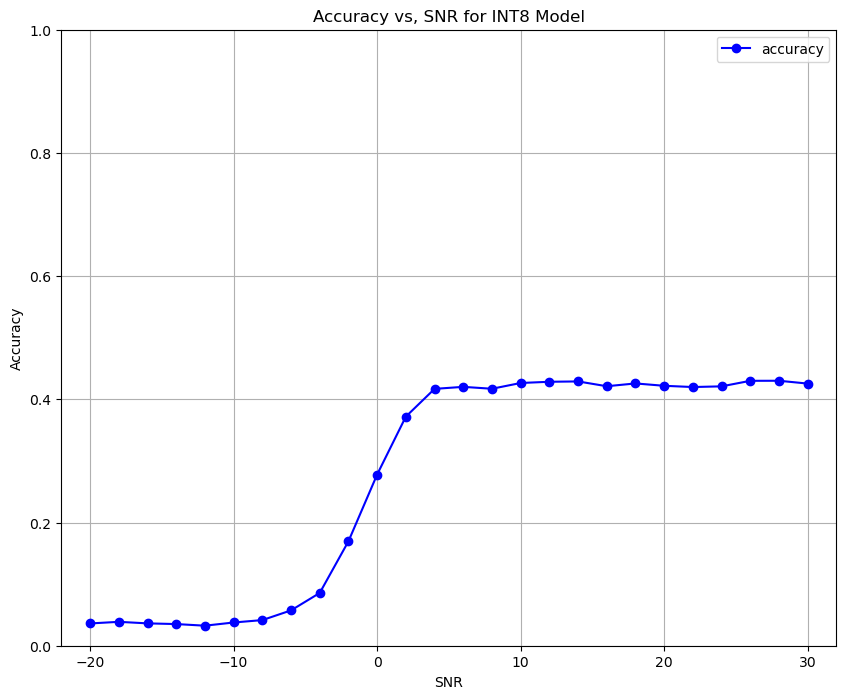

In [39]:
plt.figure(figsize=(1,1))
plt.show()
fig= plt.figure(figsize=(10,8))
plt.plot(snrlist, acc_snr_arr, 'bo-', label='accuracy')
plt.ylabel('Accuracy')
plt.xlabel('SNR')
plt.title("Accuracy vs, SNR for INT8 Model")
plt.legend()
plt.axis([-22, 32, 0, 1.0])
plt.grid()

In [72]:
batchsize = 128
progress = ProgressBar()
snrlist = np.unique(Z_test)
acc_snr_arr = []

q_model = tf.keras.models.load_model("resnet_checkpoints/model_2_quantized.h5")

# interate over SNRs
for snr in progress(snrlist):
    acc_arr = []
    i_SNR = np.where(Z_test==snr)
    X_SNR = X_test[i_SNR[0],:,:]
    Y_SNR = Y_test[i_SNR[0],:]
    X_SNR_len = np.shape(X_SNR)[0]
    total_batches = int(X_SNR_len/batchsize)
    
    for i in (range(0, total_batches)):
        x_batch, y_batch = X_SNR[i*batchsize:i*batchsize+batchsize], Y_SNR[i*batchsize:i*batchsize+batchsize]
        
        # model prediction
        pred = q_model.predict(x_batch)
        
        #Pediction values are 0-24, corresponding to indices representing different modulation types
        pred_ind = np.argmax(pred, axis=1)
        expected_ind = np.argmax(y_batch, axis=1)
        matches  = sum(np.equal(pred_ind, expected_ind))
        acc      = matches/batchsize
        acc_arr.append(acc)

    # Average the per-batch accuracy values
    accuracy = np.mean(acc_arr)
    acc_snr_arr.append(accuracy)
    print("SNR: ", snr, "accuracy", accuracy)

  0% |                                                                                                                                                                                       |

4/4 [==============================] - 0s 2ms/step


  3% |#######                                                                                                                                                                                |

SNR:  -20 accuracy 0.03651889534883721
4/4 [==============================] - 0s 1ms/step


  7% |##############                                                                                                                                                                         |

SNR:  -18 accuracy 0.03988008720930233
4/4 [==============================] - 0s 1ms/step


 11% |#####################                                                                                                                                                                  |

SNR:  -16 accuracy 0.0334051724137931
4/4 [==============================] - 0s 1ms/step


 15% |############################                                                                                                                                                           |

SNR:  -14 accuracy 0.03997093023255814
4/4 [==============================] - 0s 1ms/step


 19% |###################################                                                                                                                                                    |

SNR:  -12 accuracy 0.03815406976744186
4/4 [==============================] - 0s 1ms/step


 23% |##########################################                                                                                                                                             |

SNR:  -10 accuracy 0.04078851744186047
4/4 [==============================] - 0s 1ms/step


 26% |#################################################                                                                                                                                      |

SNR:  -8 accuracy 0.04769258720930233
4/4 [==============================] - 0s 2ms/step


 30% |########################################################                                                                                                                               |

SNR:  -6 accuracy 0.05716911764705882
4/4 [==============================] - 0s 1ms/step


 34% |###############################################################                                                                                                                        |

SNR:  -4 accuracy 0.0592296511627907
4/4 [==============================] - 0s 2ms/step


 38% |######################################################################                                                                                                                 |

SNR:  -2 accuracy 0.06640625
4/4 [==============================] - 0s 1ms/step


 42% |#############################################################################                                                                                                          |

SNR:  0 accuracy 0.08832720588235295
4/4 [==============================] - 0s 1ms/step


 46% |####################################################################################                                                                                                   |

SNR:  2 accuracy 0.11991279069767442
4/4 [==============================] - 0s 1ms/step


 50% |###########################################################################################                                                                                            |

SNR:  4 accuracy 0.1556140988372093
4/4 [==============================] - 0s 1ms/step


 53% |##################################################################################################                                                                                     |

SNR:  6 accuracy 0.1907703488372093
4/4 [==============================] - 0s 1ms/step


 57% |#########################################################################################################                                                                              |

SNR:  8 accuracy 0.1946765988372093
4/4 [==============================] - 0s 1ms/step


 61% |################################################################################################################                                                                       |

SNR:  10 accuracy 0.19195130813953487
4/4 [==============================] - 0s 1ms/step


 65% |#######################################################################################################################                                                                |

SNR:  12 accuracy 0.20137867647058824
4/4 [==============================] - 0s 1ms/step


 69% |##############################################################################################################################                                                         |

SNR:  14 accuracy 0.19522058823529412
4/4 [==============================] - 0s 2ms/step


 73% |#####################################################################################################################################                                                  |

SNR:  16 accuracy 0.19576149425287356
4/4 [==============================] - 0s 1ms/step


 76% |############################################################################################################################################                                           |

SNR:  18 accuracy 0.19576671511627908
4/4 [==============================] - 0s 1ms/step


 80% |###################################################################################################################################################                                    |

SNR:  20 accuracy 0.1943014705882353
4/4 [==============================] - 0s 1ms/step


 84% |##########################################################################################################################################################                             |

SNR:  22 accuracy 0.19779411764705881
4/4 [==============================] - 0s 1ms/step


 88% |#################################################################################################################################################################                      |

SNR:  24 accuracy 0.19231468023255813
4/4 [==============================] - 0s 2ms/step


 92% |########################################################################################################################################################################               |

SNR:  26 accuracy 0.19369612068965517
4/4 [==============================] - 0s 1ms/step


 96% |###############################################################################################################################################################################        |

SNR:  28 accuracy 0.19234913793103448
4/4 [==============================] - 0s 1ms/step


100% |#######################################################################################################################################################################################|

SNR:  30 accuracy 0.190625


<Figure size 100x100 with 0 Axes>

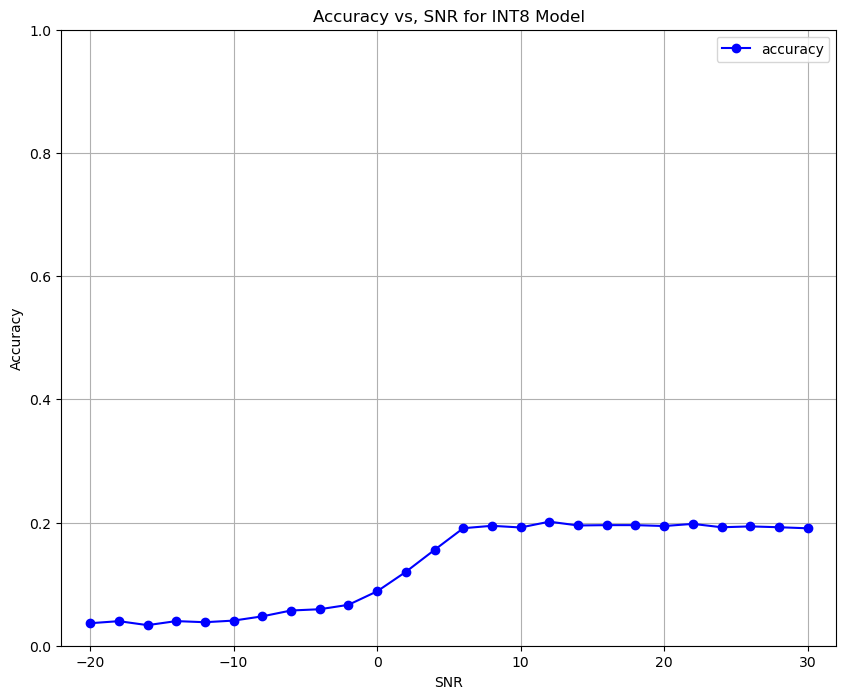

In [73]:
plt.figure(figsize=(1,1))
plt.show()
fig= plt.figure(figsize=(10,8))
plt.plot(snrlist, acc_snr_arr, 'bo-', label='accuracy')
plt.ylabel('Accuracy')
plt.xlabel('SNR')
plt.title("Accuracy vs, SNR for INT8 Model")
plt.legend()
plt.axis([-22, 32, 0, 1.0])
plt.grid()

The Accuracy vs SNR looks very similar to the floating point model.

# Quantization Aware Training test runs

In [21]:
### Callback
checkpoint_dir = 'resnet_checkpoints'
#os.mkdir(checkpoint_dir)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_dir + '/model_baseline_qat.h5', 
                                                 verbose = 1,
                                                 save_best_only=True, 
                                                 save_weights_only=False,
                                                 mode='auto')
# tb_callback = TensorBoard(log_dir=os.path.join('learner_logs', 'model_0'),
#                           histogram_freq=1,
#                           profile_batch=0)

callbacks = [cp_callback]

In [22]:
model = tf.keras.models.load_model('resnet_checkpoints/model_baseline.h5')


# *Call Vai_q_tensorflow2 api to create the quantize training model
from tensorflow_model_optimization.quantization.keras import vitis_quantize
quantizer = vitis_quantize.VitisQuantizer(model)
qat_model = quantizer.get_qat_model(
    init_quant=True, # Do init PTQ quantization will help us to get a better initial state for the quantizers, especially for the  `pof2s_tqt` strategy. Must be used together with calib_dataset
    calib_dataset=X_test[1:10000])

# Then run the training process with this qat_model to get the quantize finetuned model.
# Compile the model
qat_model.compile(
        optimizer= Adam(learning_rate=0.0001), 
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=keras.metrics.Accuracy())


# Start the training/finetuning
qat_model.fit(
    X_train,
    Y_train,
    epochs=nb_epoch,
    validation_data=(X_val, Y_val),
    verbose=1,
    callbacks=callbacks)



[VAI INFO] Using func format quantizer
[VAI INFO] Quantizing without specific `target`.
[VAI INFO] Start CrossLayerEqualization...
10/10 [==============================] - 1s 118ms/step
[VAI INFO] CrossLayerEqualization Done.
[VAI INFO] Start Generation of Quantize-aware Training Model.
[VAI INFO] Standalone activation `softmax` layer softmax is not supported.
[VAI INFO] Start Initialization with Quantize Calibration...
[VAI INFO] Update convert_to_fs_quantize_strategy: False
[VAI INFO] Quantizing without specific `target`.
[VAI INFO] Standalone activation `softmax` layer softmax is not supported.
[VAI INFO] Start Quantize Calibration...
313/313 [==============================] - 9s 20ms/step
[VAI INFO] Quantize Calibration Done.
[VAI INFO] Start Post-Quant Model Refinement...
[VAI INFO] Start Quantize Position Ajustment...
[VAI INFO] Quantize Position Ajustment Done.
[VAI INFO] Post-Quant Model Refninement Done.
[VAI INFO] Start Model Finalization...
[VAI INFO] Model Finalization Done

KeyboardInterrupt: 

# TFLite Quantization

## PTQ INT8

In [ ]:
def representative_dataset_gen():
    for data in tf.data.Dataset.from_tensor_slices(X_test[:100]).batch(1):
        yield [tf.cast(data, tf.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpvlat1y54/assets


INFO:tensorflow:Assets written to: /tmp/tmpvlat1y54/assets
/home/ashwin/anaconda3/envs/vai-tf2/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2025-05-01 18:05:57.214436: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2025-05-01 18:05:57.214449: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2025-05-01 18:05:57.214515: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvlat1y54
2025-05-01 18:05:57.215501: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2025-05-01 18:05:57.215509: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvlat1y54
2025-05-01 18:05:57.218852: I tensorflow/cc/saved

## Compile Model for DPU
The Vitis-AI compiler reads in the quantized model and generates an xmodel file which the instruction set for the Xilinx Deep Learning Processor (DPU). The arhictecture option (-a) is used to specify a json file which indicates which hw target the DPU is being compiled for.

In [15]:
# Select HW Target Choose Either Quantized or QAT (Fine Tuned Model)

#For kv260
#!vai_c_tensorflow2 -m /workspace/files/quantize_results/quantized_model.h5 -a /opt/vitis_ai/compiler/arch/DPUCZDX8G/KV260/arch.json -o vai_c_output -n rfClassification

#For ZCU104
!vai_c_tensorflow2 -m resnet_checkpoints/model_0_relu_sep_activation_no_bn_no_fft.h5 -a /opt/vitis_ai/compiler/arch/DPUCZDX8G/ZCU104/arch.json -o vai_c_output -n rfClassification

#For ZCU102 
#!vai_c_tensorflow2 -m /workspace/files/quantize_results/quantized_model.h5 -a /opt/vitis_ai/compiler/arch/DPUCZDX8G/ZCU102/arch.json -o vai_c_output -n rfClassification --options "{'cpu_arch':'arm64', 'mode':'normal', 'save_kernel':''}"

#For Alveo U50
#!vai_c_tensorflow2 -m /workspace/files/quantize_results/quantized_model.h5 -a /opt/vitis_ai/compiler/arch/DPUCAHX8H/U50/arch.json -o vai_c_output -n rfClassification --options "{'cpu_arch':'arm64', 'mode':'normal', 'save_kernel':''}"

#For Alveo U50
#!vai_c_tensorflow2 -m /workspace/files/quantize_results/quantized_model.h5 -a /opt/vitis_ai/compiler/arch/DPUCAHX8H/U50/arch.json -o vai_c_output -n rfClassification --options "{'cpu_arch':'arm64', 'mode':'normal', 'save_kernel':''}"

#For Alveo U250
#!vai_c_tensorflow2 -m /workspace/files/quantize_results/quantized_model.h5 -a /opt/vitis_ai/compiler/arch/DPUCADF8H/U250/arch.json -o vai_c_output -n rfClassification --options "{'cpu_arch':'arm64', 'mode':'normal', 'save_kernel':''}"

#For Versal VCK190
#!vai_c_tensorflow2 -m /workspace/files/quantize_results/quantized_model.h5 -a /opt/vitis_ai/compiler/arch/DPUCVDX8G/VCK190/arch.json -o vai_c_output -n rfClassification --options "{'cpu_arch':'arm64', 'mode':'normal', 'save_kernel':''}"

**************************************************
* VITIS_AI Compilation - Xilinx Inc.
**************************************************
[INFO] Namespace(batchsize=1, inputs_shape=None, layout='NHWC', model_files=['resnet_checkpoints/model_0_relu_sep_activation_no_bn_no_fft.h5'], model_type='tensorflow2', named_inputs_shape=None, out_filename='/tmp/rfClassification_DPUCZDX8G_ISA1_B4096_org.xmodel', proto=None)
[INFO] tensorflow2 model: /workspace/Tutorials/RFModulation_Recognition/files/resnet_checkpoints/model_0_relu_sep_activation_no_bn_no_fft.h5
[INFO] keras version: 2.12.0
[INFO] Tensorflow Keras model type: functional
[INFO] generate xmodel     :100%|█| 29/29 [00:00<00:00, 4715.44it/s]            
[INFO] dump xmodel: /tmp/rfClassification_DPUCZDX8G_ISA1_B4096_org.xmodel
[UNILOG][INFO] Compile mode: dpu
[UNILOG][INFO] Debug mode: null
[UNILOG][INFO] Target architecture: DPUCZDX8G_ISA1_B4096
[UNILOG][INFO] Graph name: model, with op num: 43
[UNILOG][INFO] Begin to compile...
[UNIL

In [16]:
q_model.inputs

[<KerasTensor: shape=(None, 1024, 1, 2) dtype=float32 (created by layer 'rf_input')>]

## Generate Graph Visualization with xir tool.
You will see a compiler message about the number of  subgraphs:
Total device subgraph number 3, DPU subgraph number 1 <br>
This means that are 3 subgraphs created, 1 for the input layer, 1 for for everything up the softmax layer (which runs on the DPU), and one for the softmax. <br>

The softmax layer can  optionally be acclerated in programmable logic, however in this tutorial we will implement the softmax layer on the CPU.

You can use the the xir command generate a .png file to visulize the graph layers.

In [18]:
!xir png /workspace/Tutorials/RFModulation_Recognition/files/vai_c_output/rfClassification.xmodel xmodel.png

### Write out  samples  of Test Data to be used later for HW testing
The python function we will run in the target board will read in these numpy files containing the RF data, class, and SNR.

In [11]:
# np.save('/workspace/rf_input.npy', X_test[0:1000,:,:])
# np.save('/workspace/rf_classes.npy', Y_test[0:1000])
# np.save('/workspace/rf_snrs.npy', Z_test[0:1000])
np.save('rf_input_full.npy', X_test)
np.save('rf_classes_full.npy', Y_test)
np.save('rf_snrs_full.npy', Z_test)

Now that a dpu xmodel file has been created you are ready to run on target board. You will need to copy the above 3 files, and the xmodel file from the compiler to your target board.

You can close this notebook by entering CtrlC at the console, close the docker container by entering CtrlD, and the proceed with the Tutorial readme instructions.